In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

In [13]:
# Load cleaned data
data = pd.read_csv('clean_binarized_train.csv', sep=';', decimal=',')

In [14]:
# Split data to separate 'y' and 'X'.
y = data['EXTRA_BAGGAGE']

# Drop target variable from X DataFrame
X = data.drop('EXTRA_BAGGAGE', 1)

In [ ]:
# We'll apply nested cross-validation in order to avoid the possible bias of applying 
# cross-validation combined with grid-search to perform parameter tuning.

# We'll use nested cross-validation over several classification methods in order to
# obtain their generalization score and choose the one with highest score. After this,
# we'll perform a simple cross-validation with grid-search in order to obtain the 
# best configuration of hyper-parameters for this algorithm. Finally we'll train 
# the model with all the training data and the hyper-parameter configuration that
# yield the best results.

# variace: it removes useless variables with variace equal to zero.
# scaler: standardizes each column to have mean equal to zero and variance equal to 1, 
# in order to give same importance to variables with different measurement units.
lr_pipe = Pipeline([('variance', VarianceThreshold()),
                    ('scaler', StandardScaler()),
                    ('lr', LogisticRegression(class_weight='balanced', random_state=621473))])

param_grid = dict()
param_grid['lr__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(lr_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

lr_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(lr_nested_cv_f1_scores, 'lr_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(lr_nested_cv_f1_scores), "std =", np.std(lr_nested_cv_f1_scores))
print()

##### Generalization F1 Score: mean = 0.663232566525 std = 0.00577941758843

In [ ]:
linear_svm_pipe = Pipeline([('variance', VarianceThreshold()),
                            ('scaler', StandardScaler()),
                            ('linear_svm', SVC(kernel='linear', random_state=123456, probability=True, class_weight='balanced'))])

param_grid = dict()
param_grid['linear_svm__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(linear_svm_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

linear_svm_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(linear_svm_nested_cv_f1_scores, 'linear_svm_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(linear_svm_nested_cv_f1_scores), "std =", np.std(linear_svm_nested_cv_f1_scores))
print()

In [ ]:
# We'll apply nested cross-validation in order to avoid the possible bias of applying 
# cross-validation combined with grid-search to perform parameter tuning.

# We'll use nested cross-validation over several classification methods in order to
# obtain their generalization score and choose the one with highest score. After this,
# we'll perform a simple cross-validation with grid-search in order to obtain the 
# best configuration of hyper-parameters for this algorithm. Finally we'll train 
# the model with all the training data and the hyper-parameter configuration that
# yield the best results.

# variace: it removes useless variables with variace equal to zero.
# scaler: standardizes each column to have mean equal to zero and variance equal to 1, 
# in order to give same importance to variables with different measurement units.
lr_pipe = Pipeline([('variance', VarianceThreshold()),
                    ('scaler', StandardScaler()),
                    ('lr', LogisticRegression(class_weight='balanced', random_state=621473))])

param_grid = dict()
param_grid['lr__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(lr_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

lr_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(lr_nested_cv_f1_scores, 'lr_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(lr_nested_cv_f1_scores), "std =", np.std(lr_nested_cv_f1_scores))
print()

##### Encoded:  Generalization F1 Score: mean = 0.663232566525 std = 0.00577941758843
##### Enriched: Generalization F1 Score: mean = 0.668949634197 std = 0.00667454322097
##### Binarized Generalization F1 Score: mean = 0.662300707325 std = 0.00639698194352

[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.657013, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.664832, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.651865, total=   0.7s
[CV] ...................... lr__C=0.001, score=0.654699, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...........

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.661289, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.661823, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.671862, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


[CV] ....................... lr__C=0.01, score=0.658966, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.668272, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659029, total=   0.7s
[CV] ....................... lr__C=0.01, score=0.659086, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.663437, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.658787, total=   0.7s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


[CV] ....................... lr__C=0.01, score=0.656363, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.667352, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.676885, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.662418, total=   1.0s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.659280, total=   0.8s
[CV] ........................ lr__C=0.1, score=0.658560, total=   1.0s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.669038, total=   1.1s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s


[CV] ........................ lr__C=0.1, score=0.659810, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.658972, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.663437, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.656946, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.668522, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.677245, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.662418, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s


[CV] .......................... lr__C=1, score=0.659810, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.663437, total=   0.7s
[CV] .......................... lr__C=1, score=0.668843, total=   1.1s
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.658972, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.656946, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.668522, total=   0.8s
[CV] .......................... lr__C=1, score=0.677245, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s


[CV] ......................... lr__C=10, score=0.668843, total=   1.2s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.659810, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.663437, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.658972, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.656946, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.668522, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.677245, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.7s


[CV] ........................ lr__C=100, score=0.659810, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.663437, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.656946, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.658972, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.668522, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.677245, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.658560, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   17.5s finished


[CV] ................................. , score=0.656723, total=  18.0s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.647080, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.653523, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.655475, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.664090, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.651689, total=   0.7s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


[CV] ...................... lr__C=0.001, score=0.651676, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.660730, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.658213, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.669796, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.655181, total=   0.7s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.660081, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.666931, total=   0.9s
[CV] ....................... lr__C=0.01, score=0.657635, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.662449, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.655795, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.659998, total=   0.7s
[CV] ....................... lr__C=0.01, score=0.664609, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] l

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


[CV] ....................... lr__C=0.01, score=0.676485, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.658802, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.656363, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.667310, total=   1.0s
[CV] ........................ lr__C=0.1, score=0.660664, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


[CV] ........................ lr__C=0.1, score=0.662648, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.658822, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.655987, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.659575, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.664804, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.677065, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.658999, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s


[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.662648, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.659575, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.655987, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.664804, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.676858, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.658999, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.656559, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s


[CV] ......................... lr__C=10, score=0.660664, total=   0.9s
[CV] ......................... lr__C=10, score=0.658822, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.662648, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.667504, total=   1.4s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.655987, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.659575, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.664804, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.1s


[CV] ........................ lr__C=100, score=0.667504, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.658822, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.662648, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.659575, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.655987, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.664804, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.658999, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   17.0s finished


[CV] ................................. , score=0.661815, total=  17.5s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.5s remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.651345, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.647034, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.664898, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.653506, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.651674, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.652089, total=   0.7s
[CV] l

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.660147, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.670335, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659202, total=   0.7s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV] ....................... lr__C=0.01, score=0.652152, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.658956, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.658043, total=   0.7s
[CV] ....................... lr__C=0.01, score=0.669322, total=   0.9s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.663048, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.657000, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.656769, total=   0.6s
[CV] l

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


[CV] ....................... lr__C=0.01, score=0.666200, total=   0.8s
[CV] ....................... lr__C=0.01, score=0.675490, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.653521, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.659595, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.659108, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.670285, total=   1.0s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s


[CV] ........................ lr__C=0.1, score=0.658237, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.662648, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.658387, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.657943, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.666396, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.676250, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.659987, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s


[CV] .......................... lr__C=1, score=0.662846, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.670285, total=   1.2s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.658589, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.657943, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.666396, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.676250, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.659987, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s


[CV] ......................... lr__C=10, score=0.659108, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.670285, total=   1.3s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.658237, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.662846, total=   0.6s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.658589, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.666396, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.657943, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.2s


[CV] ........................ lr__C=100, score=0.658237, total=   0.7s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.670285, total=   1.4s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.658589, total=   0.7s
[CV] ........................ lr__C=100, score=0.663044, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.657943, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.666396, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.659987, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   17.2s finished


[CV] ................................. , score=0.661119, total=  17.7s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.3s remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.655297, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.651371, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.659963, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.659950, total=   0.7s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.661069, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.655420, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.673807, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.663274, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659587, total=   0.7s


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.656837, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.664840, total=   0.9s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.664813, total=   0.9s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.662960, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.666200, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.660723, total=   0.8s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


[CV] ....................... lr__C=0.01, score=0.678046, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.667157, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.659908, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660772, total=   1.0s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.657228, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.665614, total=   1.0s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.665400, total=   1.0s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.9s


[CV] ........................ lr__C=0.1, score=0.663157, total=   1.0s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.666990, total=   1.0s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.661108, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.660685, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.678405, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.667352, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.657423, total=   1.1s
[CV] .......................... lr__C=1, score=0.660772, total=   1.1s
[CV] l

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.1s


[CV] .......................... lr__C=1, score=0.665614, total=   1.1s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.663551, total=   1.1s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.667581, total=   1.2s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.660904, total=   1.0s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.667352, total=   1.1s
[CV] .......................... lr__C=1, score=0.660685, total=   1.1s
[CV] lr__C=10 ........................................................
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.678405, total=   1.1s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s


[CV] ......................... lr__C=10, score=0.665614, total=   1.3s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.663551, total=   1.6s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.667779, total=   1.2s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.660904, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.660685, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.667352, total=   1.2s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.660968, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.1s


[CV] ........................ lr__C=100, score=0.665614, total=   1.1s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.663551, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.667779, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.660904, total=   1.2s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.667352, total=   1.1s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.660685, total=   1.3s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.678405, total=   1.2s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   21.8s finished


[CV] ................................. , score=0.664160, total=  22.5s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.646650, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.655037, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.649164, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.663094, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.653765, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


[CV] ...................... lr__C=0.001, score=0.650086, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.650277, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.669573, total=   0.4s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.660160, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.654278, total=   0.7s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV] ....................... lr__C=0.01, score=0.652539, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.661312, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659767, total=   0.6s
[CV] ....................... lr__C=0.01, score=0.667493, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.660459, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.655820, total=   0.5s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s


[CV] ....................... lr__C=0.01, score=0.664431, total=   0.5s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.654392, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.673418, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.654469, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.662897, total=   0.7s
[CV] ........................ lr__C=0.1, score=0.652735, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660536, total=   0.7s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s


[CV] ........................ lr__C=0.1, score=0.668272, total=   1.1s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.661650, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.656808, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.654984, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.664823, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.674195, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.654469, total=   0.6s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s


[CV] .......................... lr__C=1, score=0.661650, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.668272, total=   1.2s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.656808, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.654984, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.664823, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.674183, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.654469, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s


[CV] ......................... lr__C=10, score=0.660731, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.668272, total=   1.4s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.656808, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.661650, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.654984, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.664823, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.654469, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.3s


[CV] ........................ lr__C=100, score=0.668272, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.656808, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.654984, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.664823, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.674183, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.654469, total=   1.0s
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.652735, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   17.0s finished


[CV] ................................. , score=0.654992, total=  17.5s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.647252, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.664049, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.656610, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.653145, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.651746, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


[CV] ...................... lr__C=0.001, score=0.652861, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.660147, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.671700, total=   0.5s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


[CV] ....................... lr__C=0.01, score=0.656654, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.652939, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.661334, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.668466, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.656223, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.658874, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.656813, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s


[CV] ....................... lr__C=0.01, score=0.664813, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.676498, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.656057, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.653914, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.662120, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.668455, total=   1.0s
[CV] ........................ lr__C=0.1, score=0.656818, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s


[CV] ........................ lr__C=0.1, score=0.659268, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.657598, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.657353, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.656057, total=   0.8s
[CV] ........................ lr__C=0.1, score=0.665204, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.676498, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.653914, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


[CV] .......................... lr__C=1, score=0.657014, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.668455, total=   1.4s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.659466, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.657598, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.657747, total=   0.6s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.665400, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.656057, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s


[CV] ......................... lr__C=10, score=0.662120, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.657014, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.668455, total=   1.2s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.659466, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.657598, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.657747, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.665400, total=   0.6s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.5s


[CV] ........................ lr__C=100, score=0.657014, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.659466, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.668455, total=   1.3s
[CV] ........................ lr__C=100, score=0.657598, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.665400, total=   0.8s
[CV] ........................ lr__C=100, score=0.657747, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.656057, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   17.0s finished


[CV] ................................. , score=0.663950, total=  17.5s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.8min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.648792, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.654907, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.657795, total=   0.7s
[CV] ...................... lr__C=0.001, score=0.666200, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.653678, total=   0.7s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


[CV] ...................... lr__C=0.001, score=0.653651, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.670899, total=   0.5s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.663853, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.660363, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.653899, total=   0.6s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV] ....................... lr__C=0.01, score=0.663444, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.657712, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.664190, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.669790, total=   0.9s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659789, total=   0.6s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.658329, total=   0.7s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


[CV] ....................... lr__C=0.01, score=0.665946, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.678627, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660934, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.664227, total=   0.8s
[CV] ........................ lr__C=0.1, score=0.654479, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.669752, total=   1.0s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s


[CV] ........................ lr__C=0.1, score=0.659669, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.664973, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.659981, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.658911, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.678820, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.666509, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.661130, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s


[CV] .......................... lr__C=1, score=0.659863, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.665170, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.669752, total=   1.2s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.660375, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.666509, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.658708, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.678627, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s


[CV] ......................... lr__C=10, score=0.664227, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.659863, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.669752, total=   1.1s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.665170, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.660375, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.658504, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.666509, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.0s


[CV] ........................ lr__C=100, score=0.659863, total=   0.6s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.669752, total=   1.4s
[CV] ........................ lr__C=100, score=0.665170, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.660375, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.658504, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.678627, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.666509, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   17.1s finished


[CV] ................................. , score=0.660387, total=  17.6s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.1min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.651345, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.648621, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.654831, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.664849, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.656683, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


[CV] ....................... lr__C=0.01, score=0.652146, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.661516, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.668763, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.658017, total=   0.7s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV] ....................... lr__C=0.01, score=0.659740, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.667093, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.663622, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.655548, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.661860, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.661327, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.665595, total=   0.7s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


[CV] ....................... lr__C=0.01, score=0.675903, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.658999, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.661305, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.652728, total=   1.0s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.667654, total=   1.1s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s


[CV] ........................ lr__C=0.1, score=0.664610, total=   0.7s
[CV] ........................ lr__C=0.1, score=0.656111, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.662846, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.661116, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.658999, total=   0.8s
[CV] ........................ lr__C=0.1, score=0.675309, total=   0.8s
[CV] ........................ lr__C=0.1, score=0.665585, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s


[CV] .......................... lr__C=1, score=0.668043, total=   1.1s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.664408, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.662846, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.660912, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.665585, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.675697, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.658999, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s


[CV] ......................... lr__C=10, score=0.661501, total=   0.7s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.656111, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.664605, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.668237, total=   1.3s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.662846, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.675697, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.665585, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.2s


[CV] ........................ lr__C=100, score=0.668237, total=   1.2s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.664605, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.661108, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.662846, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.665585, total=   0.9s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.675697, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.658999, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   17.2s finished


[CV] ................................. , score=0.653890, total=  17.7s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.654525, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.649111, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.655825, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.663274, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.651906, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] ...................... lr__C=0.001, score=0.658481, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.654871, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.644279, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.669729, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.656641, total=   0.7s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s


[CV] ....................... lr__C=0.01, score=0.655187, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.662473, total=   0.8s
[CV] ....................... lr__C=0.01, score=0.669839, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.659815, total=   0.6s
[CV] ....................... lr__C=0.01, score=0.657139, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.663235, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.673783, total=   0.7s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s


[CV] ....................... lr__C=0.01, score=0.659169, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.646792, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.657224, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.663061, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.655375, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.670421, total=   0.9s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


[CV] ........................ lr__C=0.1, score=0.657323, total=   1.0s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660600, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.663028, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.659157, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.674159, total=   0.7s
[CV] ........................ lr__C=0.1, score=0.647186, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.657224, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s


[CV] .......................... lr__C=1, score=0.670421, total=   1.0s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.660403, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.657117, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.662826, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.647580, total=   0.8s
[CV] .......................... lr__C=1, score=0.659157, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.674365, total=   0.9s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s


[CV] ......................... lr__C=10, score=0.657117, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.670421, total=   1.2s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.660403, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.662826, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.647580, total=   0.8s
[CV] ......................... lr__C=10, score=0.659157, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.674365, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.7s


[CV] ........................ lr__C=100, score=0.657117, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.660403, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.662826, total=   0.7s
[CV] ........................ lr__C=100, score=0.670421, total=   1.4s
[CV] lr__C=100 .......................................................
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.659157, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.647580, total=   0.7s
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.674365, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.9s finished


[CV] ................................. , score=0.670325, total=  17.4s
[CV]  ................................................................
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.7min remaining:    0.0s


[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.653527, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.648301, total=   0.6s
[CV] ...................... lr__C=0.001, score=0.656013, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.665000, total=   0.5s
[CV] lr__C=0.001 .....................................................
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.653474, total=   0.6s
[CV] lr__C=0.001 .....................................................


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV] ...................... lr__C=0.001, score=0.658083, total=   0.6s
[CV] lr__C=0.001 .....................................................
[CV] ...................... lr__C=0.001, score=0.655445, total=   0.7s
[CV] ...................... lr__C=0.001, score=0.657673, total=   0.7s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.649274, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ...................... lr__C=0.001, score=0.664148, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.654575, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.657821, total=   0.7s
[CV] lr__C=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


[CV] ....................... lr__C=0.01, score=0.660716, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.658685, total=   0.6s
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.664590, total=   0.7s
[CV] ....................... lr__C=0.01, score=0.669014, total=   0.8s
[CV] lr__C=0.01 ......................................................
[CV] lr__C=0.01 ......................................................
[CV] ....................... lr__C=0.01, score=0.663235, total=   0.7s
[CV] lr__C=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s


[CV] ....................... lr__C=0.01, score=0.659923, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.653208, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ....................... lr__C=0.01, score=0.669020, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.659187, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.654771, total=   0.7s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.661101, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.669790, total=   0.9s
[CV] lr__C=0.1 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s


[CV] ........................ lr__C=0.1, score=0.664984, total=   0.8s
[CV] lr__C=0.1 .......................................................
[CV] ........................ lr__C=0.1, score=0.660512, total=   0.8s
[CV] ........................ lr__C=0.1, score=0.664022, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.653992, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] ........................ lr__C=0.1, score=0.669402, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.654967, total=   0.7s
[CV] .......................... lr__C=1, score=0.659187, total=   0.8s
[CV] lr__C=1 .........................................................
[CV] lr__C=1 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


[CV] .......................... lr__C=1, score=0.659063, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.664984, total=   0.9s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.664022, total=   0.7s
[CV] lr__C=1 .........................................................
[CV] .......................... lr__C=1, score=0.669583, total=   1.3s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.660512, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.669402, total=   0.6s
[CV] lr__C=10 ........................................................
[CV] .......................... lr__C=1, score=0.654189, total=   1.0s
[CV] lr__C=10 ........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s


[CV] ......................... lr__C=10, score=0.661697, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.659063, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.669583, total=   1.2s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.664984, total=   0.8s
[CV] lr__C=10 ........................................................
[CV] ......................... lr__C=10, score=0.660512, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ......................... lr__C=10, score=0.654189, total=   0.7s
[CV] ......................... lr__C=10, score=0.664022, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] lr__C=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.9s


[CV] ........................ lr__C=100, score=0.664984, total=   0.8s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.659063, total=   0.9s
[CV] lr__C=100 .......................................................
[CV] ........................ lr__C=100, score=0.664022, total=   0.8s
[CV] ........................ lr__C=100, score=0.669583, total=   1.3s
[CV] lr__C=100 .......................................................
[CV] lr__C=1000 ......................................................
[CV] ........................ lr__C=100, score=0.660512, total=   0.8s
[CV] ........................ lr__C=100, score=0.654189, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] lr__C=1000 ......................................................
[CV] ....................... lr__C=1000, score=0.659187, total=   0.8s
[CV] lr__C=1000 ......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   17.1s finished


[CV] ................................. , score=0.675646, total=  17.6s
##### Generalization F1 Score: mean = 0.662300707325 std = 0.00639698194352



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.0min finished


In [ ]:
linear_svm_pipe = Pipeline([('variance', VarianceThreshold()),
                            ('scaler', StandardScaler()),
                            ('linear_svm', SVC(kernel='linear', random_state=123456, probability=True, class_weight='balanced'))])

param_grid = dict()
param_grid['linear_svm__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(linear_svm_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

linear_svm_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(linear_svm_nested_cv_f1_scores, 'linear_svm_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(linear_svm_nested_cv_f1_scores), "std =", np.std(linear_svm_nested_cv_f1_scores))
print()

In [ ]:
rf_pipe = Pipeline([('variance', VarianceThreshold()),
                            ('scaler', StandardScaler()),
                            ('rf', RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=573146, class_weight='balanced'))])

param_grid = dict()
param_grid['rf__n_estimators'] = list(range(200, 1200, 150))
param_grid['rf__max_depth'] = [10, 20, 30]
param_grid['rf__min_samples_leaf'] = [50, 60, 70, 80, 90, 100]


inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(rf_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

rf_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(rf_nested_cv_f1_scores, 'rf_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(rf_nested_cv_f1_scores), "std =", np.std(rf_nested_cv_f1_scores))
print()

[CV]  ................................................................
Fitting 10 folds for each of 126 candidates, totalling 1260 fits
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.684493, total=   9.6s
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.685318, total=   9.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.695087, total=   9.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimator

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   21.7s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.688018, total=   9.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.687519, total=   9.6s
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.679468, total=   9.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.688009, total=   9.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.691328, total=   9.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.4s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.682378, total=  15.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.685077, total=  16.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.694181, total=  15.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.675445, total=  15.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686634, total=  15.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.687338, total=  16.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686238, total=  15.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.688573, total=  15.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.682173, total=  22.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686266, total=  22.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.694924, total=  23.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.675857, total=  22.5s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686405, total=  21.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.688127, total=  21.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.681210, total=  23.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.682414, total=  21.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.685616, total=  23.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.690192, total=  23.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.676840, total=  30.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.685845, total=  33.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.686963, total=  33.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.682432, total=  37.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.681805, total=  39.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.689017, total=  38.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.674850, total=  47.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.694553, total=  48.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.687447, total=  47.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.687752, total=  46.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.683028, total=  48.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.682994, total=  49.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.676623, total=  53.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.687652, total=  53.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.687557, total=  53.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.681829, total=  51.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.682023, total=  52.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.686203, total=  53.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.686634, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.686575, total= 1.2min
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.682217, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.682040, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.682077, total=  14.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.681167, total=  14.7s
[CV] rf__max_depth=10, rf__min_samp

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 12.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.683606, total=   9.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.686238, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.685674, total=   9.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.684368, total=  16.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.682358, total=  17.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.693850, total=  18.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 13.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.683740, total=  24.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.681157, total=  25.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.694804, total=  23.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.671589, total=  25.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.687664, total=  27.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.684449, total=  27.4s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 15.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.683476, total=  30.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.682375, total=  29.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.681273, total=  28.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.685207, total=  30.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.688096, total=  29.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.683534, total=  38.2s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 18.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684746, total=  46.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.682143, total=  46.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.692908, total=  44.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.672915, total=  44.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684525, total=  45.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.683292, total=  45.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 22.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.684173, total=  11.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=1100, score=0.682023, total=  58.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.679026, total=   9.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.693049, total=   9.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.671608, total=   8.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.684369, total=   9.1s
[CV] rf__max_depth=10, rf__min_samples

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 23.8min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684319, total=  15.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.683248, total=  15.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.678314, total=  15.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.682201, total=  17.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.686502, total=  18.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684193, total=  20.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 26.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.671021, total=  29.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684555, total=  32.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684071, total=  34.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.677924, total=  34.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.680039, total=  32.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684024, total=  35.2s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 29.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.692081, total=  45.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.671785, total=  44.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.684740, total=  52.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.683270, total=  53.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.679104, total=  58.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.682423, total=  58.4s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 34.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.684602, total=  10.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.687871, total=  56.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.682836, total=  12.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.677264, total=  10.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.680822, total=  10.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.682823, total=  10.4s
[CV] rf__max_depth=10, rf__min_samples

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 36.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.681018, total=  24.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.682252, total=  26.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.678259, total=  26.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.680644, total=  25.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.682496, total=  25.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.684874, total=  25.2s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 40.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.678691, total=  41.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.681899, total=  39.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685470, total=  39.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.683372, total=  51.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.679361, total=  50.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.691187, total=  50.6s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 45.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.689160, total=   8.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.669802, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=1100, score=0.682292, total=  51.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=1100, score=0.685274, total=  50.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.683364, total=   9.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.683589, total=  10.0s
[CV] rf__max_depth=10, rf__min_sample

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed: 47.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.683236, total=  22.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.680684, total=  23.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.678479, total=  24.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.679702, total=  25.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.684298, total=  25.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650, score=0.681814, total=  31.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed: 52.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.681814, total=  52.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.679780, total=  52.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.690774, total=  47.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.670043, total=  45.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.682201, total=  48.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.682641, total=  49.6s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 57.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.678516, total=  10.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.681869, total=   9.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.682737, total=   9.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.681619, total=  18.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.679008, total=  18.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.689438, total=  17.2s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 60.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.681485, total=  30.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.681036, total=  32.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.675787, total=  32.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.676156, total=  33.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.683702, total=  34.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.680299, total=  36.2s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 66.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.670769, total=  54.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.682610, total=  57.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.682491, total=  57.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.674819, total=  52.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.677533, total=  53.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.687709, total=  12.2s
[CV] rf__max_depth=20, rf_

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 69.5min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.696335, total=  23.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.681148, total=  22.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.690993, total=  23.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.688177, total=  24.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.683950, total=  25.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686665, total=  27.5s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed: 75.0min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.681897, total=  43.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.688854, total=  43.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.687946, total=  44.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.685335, total=  43.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.683988, total=  44.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.694609, total=  44.7s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 79.4min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.685021, total=  15.7s
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.683724, total=  16.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.681257, total=  16.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.683010, total=  15.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.685085, total=  15.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.688723, total=  16.0s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 84.9min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.682992, total=  46.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.687181, total=  43.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.686271, total=  43.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.686931, total=  55.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684060, total=  54.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.679814, total=  54.5s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed: 92.3min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.685569, total=  22.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.679995, total=  24.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.693242, total=  24.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.674927, total=  26.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.685110, total=  22.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.682469, total=  21.6s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 97.2min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.682091, total=  36.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.679632, total=  36.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.681648, total=  36.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.686985, total=  36.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.685281, total=  35.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.683804, total=  43.4s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 103.0min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.679408, total=  18.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.681267, total=  19.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.691526, total=  18.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.671589, total=  19.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.684155, total=  15.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.684414, total=  15.4s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 107.9min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.679484, total=  39.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.684874, total=  38.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.682718, total=  37.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681423, total=  43.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681196, total=  43.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.692921, total=  42.3s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed: 114.4min


[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.684340, total=  18.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.680747, total=  18.5s
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.676939, total=  17.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.678291, total=  17.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.683105, total=  17.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.683281, total=  18.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed: 120.2min


[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.673541, total=  42.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.681427, total=  43.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.679156, total=  44.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.678523, total=  42.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.678735, total=  43.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.682661, total=  47.0s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 125.3min


[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.690750, total=  21.8s
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.669839, total=  21.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.680048, total=  22.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.681690, total=  21.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.679317, total=  21.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.676354, total=  21.4s
[CV] rf__max_depth=20, rf__min_sa

[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed: 132.7min


[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.671021, total=  53.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.679664, total=  52.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.680131, total=  51.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.675973, total=  52.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.679106, total=  53.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.687720, total=  12.8s
[CV] rf__max_depth=30, rf_

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 137.8min


[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.686587, total=  31.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.689403, total=  32.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.686291, total=  34.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.682778, total=  34.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.690217, total=  33.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.693784, total=  33.2s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed: 146.1min


[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.690272, total=   9.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.682396, total=  10.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.685831, total=   9.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.688921, total=  17.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.683086, total=  17.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.696227, total=  17.5s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed: 152.2min


[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.686519, total=  59.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.683876, total=  57.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.695992, total=  50.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.680397, total=  51.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684330, total=  47.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.686210, total=  49.2s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 159.6min


[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.681474, total=  29.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.680261, total=  32.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.681586, total=  33.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.689192, total=  31.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.684108, total=  30.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684173, total=  40.8s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1050 tasks      | elapsed: 168.8min


[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.691964, total=  10.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.672330, total=   9.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.685160, total=   9.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.687581, total=  50.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.684495, total=  51.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.684025, total=   8.8s
[CV] rf__max_depth=30, rf__min_sample

[Parallel(n_jobs=-1)]: Done 1097 tasks      | elapsed: 175.0min


[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.679484, total=  48.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.684874, total=  43.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.682718, total=  42.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681196, total=  43.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681423, total=  44.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.692921, total=  47.1s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 182.5min


[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.683959, total=  23.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.681117, total=  22.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.678706, total=  21.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.676939, total=  23.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.682457, total=  22.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.682521, total=  22.4s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 190.5min


[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=1100, score=0.683505, total=  42.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.681712, total=   7.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.680635, total=   7.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.672622, total=   7.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.679868, total=   7.7s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.681061, total=   7.9s
[CV] rf__max_depth=30, rf__min_sa

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 196.1min


[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.690556, total=  37.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.669839, total=  37.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.679648, total=  36.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.679936, total=  37.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.675963, total=  37.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.678523, total=  36.9s
[CV] rf__max_depth=30, rf__min_s

[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 199.4min finished


[CV] ................................ , score=0.688066, total=199.7min
[CV]  ................................................................
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 199.7min remaining:    0.0s


[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.675056, total=   8.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686564, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.679861, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.690879, total=   8.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.9s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.680044, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.679664, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686790, total=   8.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686692, total=   8.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   30.1s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.680932, total=  14.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.684810, total=  15.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.690311, total=  14.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.674826, total=  14.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.683529, total=  14.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686634, total=  14.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.679256, total=  15.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.687562, total=  14.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686299, total=  14.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.684400, total=  22.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.682348, total=  20.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.688966, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.682797, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.683703, total=  20.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.679505, total=  20.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.677302, total=  21.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686882, total=  20.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.685216, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.682201, total=  26.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.683734, total=  27.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.679136, total=  26.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.677709, total=  27.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.685616, total=  26.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.684712, total=  26.6s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.689184, total=  34.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.672145, total=  34.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.682032, total=  32.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.683929, total=  33.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.679721, total=  33.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.676956, total=  32.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.0min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.672556, total=  39.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.683539, total=  39.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.682219, total=  40.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.679894, total=  39.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.676962, total=  38.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.686221, total=  39.4s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  8.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.683010, total=  45.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.683539, total=  44.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.678540, total=  46.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.675965, total=  45.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.683362, total=   8.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.680395, total=   8.6s
[CV] rf__max_depth=10, rf__min_samp

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  9.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.677140, total=   8.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.684737, total=   8.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.682857, total=   8.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.683199, total=  14.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.681000, total=  14.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.691575, total=  14.5s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 10.4min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.680838, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.681782, total=  20.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.690592, total=  20.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.672956, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.680872, total=  20.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.685673, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 12.4min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.679125, total=  34.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.674600, total=  34.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.682269, total=  32.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.685512, total=  33.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.681639, total=  40.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.681400, total=  42.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.8min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.681996, total=  40.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.681853, total=  41.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.688625, total=  43.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.671422, total=  47.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.680684, total=  53.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684699, total=  52.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 18.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=1100, score=0.675779, total=  49.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.678562, total=   9.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.679761, total=   9.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.688476, total=   8.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.670868, total=   8.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=1100, score=0.683870, total=  49.1s
[CV] rf__max_depth=10, rf__min_sample

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 20.0min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.678895, total=  15.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.676559, total=  15.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.683139, total=  16.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.674765, total=  16.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684066, total=  14.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.685463, total=  15.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 22.4min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.679091, total=  29.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.681987, total=  31.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.676969, total=  30.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.674979, total=  31.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684074, total=  31.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.684915, total=  29.9s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 25.4min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.686495, total=  39.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.669064, total=  40.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.679491, total=  39.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.680226, total=  39.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.676802, total=  39.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.675971, total=  40.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 29.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.684254, total=  48.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.682934, total=  47.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.684350, total=   8.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.677183, total=   8.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.674012, total=   8.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.683069, total=   8.5s
[CV] rf__max_depth=10, rf__min_sample

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 30.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.678847, total=  20.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.682543, total=  21.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.676569, total=  20.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.674798, total=  21.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.684050, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.686903, total=  20.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 34.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.674412, total=  33.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.684458, total=  33.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685137, total=  32.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681108, total=  40.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.679060, total=  40.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.688030, total=  40.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 38.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.687057, total=   9.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=1100, score=0.684866, total=  45.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=1100, score=0.684934, total=  45.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.665524, total=   7.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.679091, total=   8.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.682123, total=   8.3s
[CV] rf__max_depth=10, rf__min_sample

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed: 40.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.681527, total=  20.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.672869, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.672026, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.680668, total=  20.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.683537, total=  20.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650, score=0.680512, total=  26.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed: 43.8min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.679516, total=  39.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.678116, total=  39.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.687458, total=  39.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.668442, total=  39.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.679920, total=  38.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.680571, total=  39.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 47.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.670441, total=   8.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.684450, total=   8.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.685885, total=   8.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.679321, total=  14.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.678412, total=  14.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.687274, total=  14.4s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 50.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.676943, total=  26.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.677638, total=  26.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.674266, total=  25.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.671036, total=  26.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.682285, total=  25.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.684495, total=  26.6s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 55.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.665706, total=  44.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.676136, total=  44.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.678608, total=  44.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.676429, total=  45.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.672623, total=  44.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686996, total=   9.9s
[CV] rf__max_depth=20, rf_

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 58.6min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.693365, total=  23.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.680385, total=  22.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.687101, total=  23.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686690, total=  23.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.683213, total=  23.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.680064, total=  22.8s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed: 63.6min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.678395, total=  43.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.688508, total=  44.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.685910, total=  43.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.684231, total=  43.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.681444, total=  43.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.692218, total=  43.5s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 67.9min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.685170, total=  15.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.687057, total=  15.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.681496, total=  15.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.679264, total=  16.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.688148, total=  15.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.684481, total=  15.6s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 72.6min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.677330, total=  43.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.685999, total=  43.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.685870, total=  44.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.683239, total=  54.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.681558, total=  54.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.691719, total=  49.6s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed: 78.0min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.683620, total=  15.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.680562, total=  15.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.690918, total=  16.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.674678, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.681000, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684514, total=  15.3s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 82.3min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.682983, total=  34.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.677993, total=  33.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.677553, total=  34.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.685438, total=  34.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.683925, total=  34.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.682868, total=  40.3s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 87.5min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.681338, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.678355, total=  15.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.687764, total=  15.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.671990, total=  15.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.679256, total=  14.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.682143, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 92.1min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.675198, total=  43.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685099, total=  38.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.683862, total=  43.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.680546, total=  51.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.679613, total=  52.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.688590, total=  48.9s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed: 97.6min


[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.679256, total=  15.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.681743, total=  14.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.675610, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.673603, total=  15.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.684441, total=  14.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.683734, total=  15.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed: 102.8min


[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.670852, total=  39.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.677513, total=  38.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.680804, total=  39.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.677425, total=  39.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.674012, total=  38.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.683273, total=  39.6s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 107.4min


[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.684730, total=  21.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.667855, total=  20.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.676516, total=  20.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.681558, total=  20.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.676616, total=  20.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=500, score=0.674210, total=  20.6s
[CV] rf__max_depth=20, rf__min_sa

[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed: 114.4min


[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.667291, total=  47.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.675756, total=  44.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.679817, total=  45.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.676402, total=  44.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.673028, total=  44.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686596, total=   9.6s
[CV] rf__max_depth=30, rf_

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 118.6min


[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.687122, total=  28.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.685910, total=  29.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.683419, total=  29.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.681461, total=  30.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.693979, total=  28.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.687236, total=  28.3s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed: 125.9min


[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.679695, total=   9.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.686017, total=   9.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.685674, total=   9.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.685611, total=  16.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.684277, total=  15.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.692054, total=  15.7s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed: 131.2min


[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.683239, total=  41.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.681558, total=  41.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.674596, total=  45.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.691732, total=  46.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.683783, total=  54.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684319, total=  51.6s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 137.7min


[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.684555, total=  21.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.677356, total=  21.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.677965, total=  22.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.684325, total=  21.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=500, score=0.686594, total=  22.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.683063, total=  28.4s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1050 tasks      | elapsed: 145.4min


[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.687582, total=   8.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.672595, total=   8.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.684041, total=  46.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.685112, total=  47.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.679868, total=   8.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.682697, total=   8.7s
[CV] rf__max_depth=30, rf__min_sample

[Parallel(n_jobs=-1)]: Done 1097 tasks      | elapsed: 150.4min


[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.675395, total=  38.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.683862, total=  40.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685295, total=  39.2s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.680546, total=  50.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.679613, total=  51.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.688590, total=  47.5s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 158.9min


[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.678691, total=  26.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.681400, total=  26.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.674990, total=  25.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.675041, total=  28.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.683854, total=  27.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.682742, total=  28.0s
[CV] rf__max_depth=30, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 168.7min


[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.678872, total=   9.4s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=90, rf__n_estimators=1100, score=0.684318, total= 1.0min
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.681382, total=  10.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.674837, total=  10.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.674012, total=  11.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.683001, total=  12.5s
[CV] rf__max_depth=30, rf__min_sa

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 176.8min


[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.687069, total=  58.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.667291, total=  55.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.675373, total= 1.0min
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.678447, total=  56.5s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.676197, total=  54.3s
[CV] rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=30, rf__min_samples_leaf=100, rf__n_estimators=950, score=0.673237, total=  55.1s
[CV] rf__max_depth=30, rf__min_s

[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 181.7min finished


[CV] ................................ , score=0.686996, total=181.8min
[CV]  ................................................................
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 381.5min remaining:    0.0s


[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.682799, total=  11.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.675306, total=  12.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.689092, total=  12.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.679947, total=  13.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   26.9s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.687388, total=  11.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.684033, total=  12.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.680048, total=  11.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686867, total=  12.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.686399, total=  12.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   41.6s


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.680428, total=  20.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.679507, total=  19.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.690283, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.675479, total=  21.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.683215, total=  19.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.687400, total=  20.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.679452, total=  21.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686185, total=  20.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=350, score=0.686648, total=  19.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.681782, total=  27.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.678745, total=  28.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.688929, total=  28.1s
[CV]  rf__max_depth=10, rf__min_samples

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.683178, total=  27.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.687788, total=  26.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.679460, total=  25.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.680639, total=  26.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686008, total=  30.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.687252, total=  32.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.675662, total=  39.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.683606, total=  39.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.686623, total=  39.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.681028, total=  40.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.679876, total=  39.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=650, score=0.685616, total=  39.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.676074, total=  48.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.688292, total=  49.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.685170, total=  53.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.686039, total=  52.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.681039, total=  49.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=800, score=0.680676, total=  50.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  8.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.675879, total=  57.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.684955, total=  57.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.686039, total=  57.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.680650, total=  57.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.680706, total=  58.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.687004, total= 1.0min
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.685150, total= 1.4min
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.686817, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.681051, total= 1.1min
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=50, rf__n_estimators=1100, score=0.679695, total= 1.1min
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.685489, total=  10.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.676246, total=   9.4s
[CV] rf__max_depth=10, rf__min_samp

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 14.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.679120, total=  11.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.685561, total=  12.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=200, score=0.686998, total=  11.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.683804, total=  22.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.674700, total=  22.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.688302, total=  21.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 15.5min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.684184, total=  28.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.676496, total=  28.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.688670, total=  29.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.675067, total=  30.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.684155, total=  29.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=500, score=0.685373, total=  30.6s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 17.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.685810, total=  33.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.681257, total=  33.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.679324, total=  33.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.685207, total=  33.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=650, score=0.688437, total=  33.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.681238, total=  42.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 20.6min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.681434, total=  49.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.676691, total=  49.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.688692, total=  48.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.674494, total=  49.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684545, total= 1.0min
[CV] rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.685627, total= 1.0min
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 26.3min


[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=1100, score=0.678523, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.682550, total=  12.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.679220, total=  13.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=60, rf__n_estimators=1100, score=0.685589, total= 1.3min
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.687122, total=  12.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=200, score=0.674013, total=  14.3s
[CV] rf__max_depth=10, rf__min_sample

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 27.8min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.683149, total=  23.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.683807, total=  22.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.680879, total=  23.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.679256, total=  22.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684211, total=  20.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.685077, total=  23.0s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 31.0min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.681391, total=  56.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.682513, total=  56.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.678887, total=  53.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.680706, total=  55.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.685589, total=  50.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=650, score=0.685681, total=  44.8s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 35.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.689254, total=  59.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.674266, total=  59.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.682592, total=  56.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.683097, total=  56.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.679341, total=  54.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.680276, total=  57.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 41.1min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.686268, total=  10.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=70, rf__n_estimators=1100, score=0.685309, total= 1.1min
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.683613, total=  12.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.678865, total=  12.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.677343, total=  11.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=200, score=0.686752, total=  13.0s
[CV] rf__max_depth=10, rf__min_samples

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 43.4min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.683559, total=  33.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.684460, total=  31.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.679666, total=  30.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.676359, total=  29.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.686371, total=  28.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=500, score=0.686036, total=  29.7s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 47.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.677350, total=  47.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685179, total=  50.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.684866, total=  49.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.681013, total= 1.0min
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.675923, total= 1.0min
[CV] rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.688670, total= 1.1min
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 54.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.688270, total=   9.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.671875, total=   9.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.682102, total=   9.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.684778, total=   9.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200, score=0.679104, total=   8.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=80, rf__n_estimators=1100, score=0.683898, total=  50.8s
[CV] rf__max_depth=10, rf__min_samples

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed: 56.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.682112, total=  21.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.679299, total=  22.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.677146, total=  22.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.681648, total=  20.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=500, score=0.685092, total=  24.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=650, score=0.678876, total=  29.1s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed: 59.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.680838, total=  42.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.674947, total=  43.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.688097, total=  41.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.673304, total=  40.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.679995, total=  39.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=90, rf__n_estimators=950, score=0.681701, total=  39.3s
[CV] rf__max_depth=10, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 64.2min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.678502, total=   7.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.682261, total=   8.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=200, score=0.687478, total=   8.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.681326, total=  13.8s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.674732, total=  14.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=350, score=0.689196, total=  14.2s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 66.7min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.680431, total=  24.9s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.682902, total=  26.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.674759, total=  26.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.676344, total=  28.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.683802, total=  27.7s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=800 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=650, score=0.686081, total=  28.4s
[CV] rf__max_depth=10, rf__min_sa

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 71.9min


[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.670534, total=  44.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.680004, total=  45.6s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.682491, total=  47.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100 
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.676949, total=  47.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=10, rf__min_samples_leaf=100, rf__n_estimators=1100, score=0.676143, total=  47.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=200, score=0.688386, total=   9.5s
[CV] rf__max_depth=20, rf_

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 74.8min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.693115, total=  22.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.679559, total=  24.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.687869, total=  24.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.689791, total=  23.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.683758, total=  25.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=650 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=500, score=0.686073, total=  26.1s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed: 80.1min


[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.680942, total=  47.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.687858, total=  43.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.689449, total=  43.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.683370, total=  44.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.684915, total=  47.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=1100 
[CV]  rf__max_depth=20, rf__min_samples_leaf=50, rf__n_estimators=950, score=0.695312, total=  41.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 84.5min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.686895, total=  17.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.687412, total=  15.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.681999, total=  16.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.682768, total=  17.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.687407, total=  16.9s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=350, score=0.690639, total=  17.7s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 89.3min


[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.683383, total=  36.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.690077, total=  35.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=800, score=0.686467, total=  38.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.684540, total=  43.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.679655, total=  44.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=60, rf__n_estimators=950, score=0.693735, total=  45.5s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed: 94.6min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.682234, total=  16.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.679984, total=  15.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.690774, total=  15.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.674861, total=  15.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.687252, total=  15.7s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=350, score=0.684071, total=  17.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 99.0min


[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.683724, total=  36.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.680078, total=  36.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.681018, total=  35.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.687142, total=  35.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=800, score=0.686860, total=  35.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=70, rf__n_estimators=950, score=0.683014, total=  42.8s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 104.7min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.682634, total=  16.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.689609, total=  16.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.677035, total=  17.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.674049, total=  16.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.683129, total=  16.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=350, score=0.678282, total=  16.2s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 109.4min


[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.680684, total=  36.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.686371, total=  36.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=800, score=0.685478, total=  36.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.683435, total=  40.8s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.678270, total=  41.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=80, rf__n_estimators=950, score=0.689254, total=  44.3s
[CV] rf__max_depth=20, rf__min_samples_

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed: 114.9min


[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.683692, total=  16.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.685650, total=  15.5s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.678530, total=  16.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.680039, total=  14.6s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.686146, total=  16.1s
[CV] rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=500 .
[CV]  rf__max_depth=20, rf__min_samples_leaf=90, rf__n_estimators=350, score=0.686482, total=  16.9s
[CV] rf__max_depth=20, rf__min_samples_

In [12]:
# Function to plot boxplot of nested cross-validation scores.
def plot_cv_scores(cv_scores):
    print(cv_scores)
    print()
    
    sns.set_style("whitegrid")
    
    ax = sns.boxplot(x=cv_scores, orient="v")
    
    plt.show()

[ 0.65955281  0.66496946  0.65845868  0.66442867  0.65624142  0.66287029
  0.66266614  0.65689413  0.67110565  0.67513841]



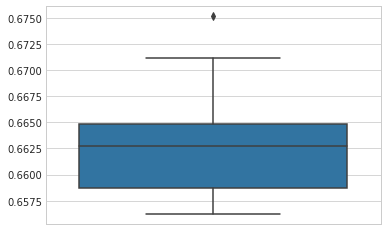

In [13]:
lr_nested_cv_f1_scores = joblib.load('lr_nested_cv_f1_scores.pkl')

plot_cv_scores(lr_nested_cv_f1_scores)

In [14]:
def plot_variable_ranking(model, model_type, column_names):
    if model_type == "rf":
        importance = model.feature_importances_
        importance = pd.DataFrame(importance, index=column_names, columns=["Importance"])
        importance["Std"] = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
        
        x = range(importance.shape[0])
        y = importance.ix[:, 0]        
        yerr = importance.ix[:, 1]
        
        plt.bar(x, y, yerr=yerr, align="center")
        plt.xticks(range(len(column_names)), column_names)
        plt.show()
    elif model_type == "lr":
        importance = model.coef_
        importance = pd.DataFrame(importance, index=column_names, columns=["Importance"])
        
        x = range(importance.shape[0])
        y = importance.ix[:, 0]        
        
        plt.bar(x, y, align="center")
        plt.xticks(range(len(column_names)), column_names)
        plt.show()

In [15]:
pca_lr_pipe = Pipeline([('variance', VarianceThreshold()),
                    ('scaler', StandardScaler()),
                    ('pca', PCA(random_state=554197)),
                    ('lr', LogisticRegression(class_weight='balanced', random_state=621473))])

param_grid = dict()
param_grid['lr__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid['pca__n_components'] = list(range(2, 14, 2))

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(pca_lr_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

pca_lr_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(pca_lr_nested_cv_f1_scores, 'pca_lr_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(pca_lr_nested_cv_f1_scores), "std =", np.std(pca_lr_nested_cv_f1_scores))
print

##### Generalization F1 Score: mean = 0.660731584574 std = 0.00561434867445

[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_c

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s


[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.66750374936852, total=   0.8s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6685796949041574, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s


[CV]  pca__n_components=4, lr__C=0.001, score=0.6402838091784187, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.001, score=0.644956788834904, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6452904196874459, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6358784026486193, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6398892955228245, total=   0.8s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6386762050891316, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6640153679404277, total=   0.8s
[CV]  pca__n_co

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s


[CV]  pca__n_components=6, lr__C=0.001, score=0.6478903727121639, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6358910291980275, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6372472183751655, total=   0.7s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6410652366155195, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6420882194356852, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s


[CV]  pca__n_components=6, lr__C=0.001, score=0.6412387898145311, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6536734863242419, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6474863268128395, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6606271651632819, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6473585706928499, total=   1.0s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6434387336893721, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6434873061300582, total=   1.1s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6534376474950544, total=   1.0s
[CV] 

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.9s


[CV]  pca__n_components=8, lr__C=0.001, score=0.6710611153947622, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6452780446123658, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6560028643476468, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6436485705734976, total=   1.1s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6493454091772118, total=   1.4s
[CV]  pca__n_components=10, lr__C=0.001, score=0.651487130089051, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6426753616459757, total=   1.1s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.0s


[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6616891723850032, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6523281901343214, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6516855837878811, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6600724768743462, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6570372564650998, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.657071652212065, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6546743555047586, total=   0.6s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pc

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.8s


[CV]  pca__n_components=2, lr__C=0.01, score=0.644767779237654, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6497165819496991, total=   0.5s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.651724437933098, total=   0.7s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6512857643211476, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6693245528293064, total=   0.6s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6708933789980793, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.01, score=0.6463210181227942, total=   0.7s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.8s


[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6418846179373868, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.01, score=0.6584881237499707, total=   0.7s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6484805946951578, total=   0.8s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6651406434175484, total=   0.7s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6407795365337544, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.642287599925224, total=   0.7s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr_

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    8.2s


[CV]  pca__n_components=8, lr__C=0.01, score=0.658159634254066, total=   0.8s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6489712822683593, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6568749173207514, total=   0.8s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6450889402856467, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.01, score=0.653074699942534, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.662168422352572, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6601895000355632, total=   0.9s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV] pca__n_components=1

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.8s


[CV]  pca__n_components=12, lr__C=0.01, score=0.6601338113583685, total=   0.6s
[CV]  pca__n_components=10, lr__C=0.01, score=0.657631035434698, total=   1.0s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6530248535411234, total=   0.6s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6633384702216283, total=   0.9s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6607368746210178, total=   1.0s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6645288574559896, total=   0.6s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.656241266027067, total=   0.6s
[CV]  pca__n_com

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   11.0s


[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6521171536325109, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6447613358160793, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6497089947672674, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6514734565196282, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6691151971644079, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6706692995192061, total=   0.6s
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV]  pca__n_components=4, lr__C=0.

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.3s


[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6417730700675718, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6392629849604625, total=   0.7s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6518770197106766, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6432804534580095, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6440911434763325, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.1, score=0.640668165535875, total=   1.0s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6558373868084182, total=   0.9s
[CV] pca__n_components=8, lr_

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   14.1s


[CV]  pca__n_components=8, lr__C=0.1, score=0.6756284054789671, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6591466090285627, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6665512796932016, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6530335719045807, total=   1.2s
[CV]  pca__n_components=10, lr__C=0.1, score=0.656431144203745, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6564274110069341, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6637840620953321, total=   1.2s
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.8s


[CV]  pca__n_components=2, lr__C=1, score=0.6558131717011122, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.64824206927581, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6456673858267585, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6538573689656502, total=   0.8s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6449580753662768, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6521171536325109, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6497089947672674, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ..........

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   17.3s


[CV]  pca__n_components=4, lr__C=1, score=0.6657258541977391, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6417730700675718, total=   0.9s
[CV]  pca__n_components=6, lr__C=1, score=0.6430894413576784, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6520759651154471, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6392629849604625, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6408694955766743, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.643481333028101, total=   0.9s
[CV]  pca__n_components=6, lr__C=1, score=0

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   19.3s


[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6532270776074283, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6673415799692902, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6570138234277363, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6570331849085626, total=   1.1s
[CV]  pca__n_components=10, lr__C=1, score=0.6639812398828786, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6609895247559032, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ......

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   21.3s


[CV]  pca__n_components=2, lr__C=10, score=0.6456673858267585, total=   0.7s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6449580753662768, total=   0.7s
[CV]  pca__n_components=2, lr__C=10, score=0.6497089947672674, total=   0.5s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6514734565196282, total=   0.5s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6693068717276078, total=   0.5s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6706692995192061, total=   0.6s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, score=0.643291705323791, total=   0.7s
[CV] pca__n_components=6, lr__C=10 .

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   23.2s


[CV] pca__n_components=8, lr__C=10 ...................................
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6558373868084182, total=   0.8s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=6, lr__C=10, score=0.6647931687098615, total=   0.9s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.650137998671875, total=   0.9s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.650275302708641, total=   0.9s
[CV]  pca__n_components=8, lr__C=10, score=0.6577397612479058, total=   0.8s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6456898920432671, total=   0.9s
[CV]  pca__n_components=8, lr__C=10, score=

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   25.6s


[CV]  pca__n_components=12, lr__C=10, score=0.6546105238671684, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.657824509745742, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6664288481404959, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6596690183980252, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6647868953698792, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6590103898051665, total=   0.7s
[CV] pca__n_components=2, lr__C=100 

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   27.5s


[CV]  pca__n_components=4, lr__C=100, score=0.6484805946951578, total=   0.7s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6422810989069068, total=   0.9s
[CV]  pca__n_components=4, lr__C=100, score=0.6586841905406294, total=   0.8s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6657258541977391, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6430894413576784, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6417730700675718, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6392629849604625, total=   0.9s
[CV] pca__n_components=8, lr

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   30.2s


[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6572310716910471, total=   1.1s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.6607023391649307, total=   0.7s
[CV]  pca__n_components=10, lr__C=100, score=0.6609895247559032, total=   1.0s
[CV]  pca__n_components=10, lr__C=100, score=0.6619084438499344, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=2, lr__C=1000 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6635438533175297, total=   1.1s
[CV] pca__n_components=2, lr__C=1000 .................................
[CV]  pca__n_components=10, lr__C=100

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   32.1s


[CV]  pca__n_components=2, lr__C=1000, score=0.6706692995192061, total=   0.6s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6430917275018659, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6467163316027793, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6480788422410133, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.637645503462284, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6396876220155028, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6424915531099341, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   34.9s


[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=8, lr__C=1000, score=0.6760291115870845, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.659733733443546, total=   1.0s
[CV]  pca__n_components=10, lr__C=1000, score=0.6671465961136537, total=   0.9s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6532270776074283, total=   1.0s
[CV]  pca__n_components=10, lr__C=1000, score=0.6568183882428634, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6572310716910471, total=   1.2s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=1

[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   36.5s finished


[CV] ....................... , score=0.6551115422641698, total=  37.0s
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.0s remaining:    0.0s


[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6537175347543855, total=   0.5s
[CV] pca__n_components=4, lr__C=0.001 ..............................

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s


[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6493713149951189, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6669104075579783, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6693811950374, total=   0.6s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6382785260769972, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.645581481130575, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s


[CV]  pca__n_components=4, lr__C=0.001, score=0.6456897422499271, total=   0.6s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6366782304297316, total=   0.6s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6380774705537938, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6412903042684525, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6406918231618067, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6470905231489301, total=   0.9s
[CV]  pca__n_components=4, lr__C=0.001, score=0.664192956961144, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s


[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6583149502056481, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6369868560188398, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6411530258797863, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6496900603852476, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6360921731912345, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6366139888683738, total=   0.7s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s


[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6508877012074368, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=6, lr__C=0.001, score=0.660246830412504, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.63984098496059, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.653257459692877, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6479818218438528, total=   1.1s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6428591828209217, total=   1.0s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.642078748509659, total=   1.0s
[CV] pca__n_compone

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.5s


[CV]  pca__n_components=8, lr__C=0.001, score=0.6550799268714215, total=   0.8s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6703346843633342, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.648379209107776, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6396576367537593, total=   0.8s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6418620868506506, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6492901026759278, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6436622168511885, total=   1.1s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca_

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.6s


[CV]  pca__n_components=12, lr__C=0.001, score=0.6491804135443863, total=   0.6s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6504869189836598, total=   0.4s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6584783024683333, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6532840020313282, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6548470442255088, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12,

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.5s


[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6451480084340125, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.01, score=0.651724437933098, total=   0.7s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6687317532995783, total=   0.5s
[CV]  pca__n_components=2, lr__C=0.01, score=0.649905193335731, total=   0.7s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.671647573183643, total=   0.5s
[CV]  pca__n_components=2, lr__C=0.01, score=0.652282018264721, total=   0.6s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.5s


[CV]  pca__n_components=4, lr__C=0.01, score=0.6422810989069068, total=   0.8s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6598425298705375, total=   0.7s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.666126182516065, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6394450043093884, total=   0.7s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6455780046115579, total=   0.9s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6524737408958041, total=   0.9s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6388788465508608, total=   0.9s
[CV] pca__n_components

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    7.8s


[CV]  pca__n_components=8, lr__C=0.01, score=0.6529503028302261, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6573719695303131, total=   0.8s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6480891345146004, total=   1.1s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6489712822683593, total=   1.1s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6462894125921926, total=   1.0s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.656876871184988, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6510872300662044, total=   1.0s
[CV] pca__n_components

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.3s


[CV]  pca__n_components=10, lr__C=0.01, score=0.661019786913909, total=   0.9s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6566660903621852, total=   0.7s
[CV]  pca__n_components=12, lr__C=0.01, score=0.649042130237058, total=   0.6s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6570519642424272, total=   1.1s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6589780471007046, total=   0.9s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6643649186053603, total=   0.7s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6726052382412993, total=   1.0s
[CV]  pca__n_com

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.6s


[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.652705951789045, total=   0.5s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6689234910377108, total=   0.5s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6501013549794544, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6518736018049098, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6716313990016395, total=   0.5s
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV]  pca__n_components=4, lr__C=0.1, score=0.647567153748227, total=   0.7s
[CV] pca__n_components=6, lr__C=0.1 .

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.9s


[CV]  pca__n_components=6, lr__C=0.1, score=0.6453787337303792, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6402487119931282, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6520738257529913, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6390777137730687, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6406523036660634, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6406879916521117, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6434648004932988, total=   0.8s
[CV] pca__n_components=8, lr

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   13.9s


[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.667371989306857, total=   0.9s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6504438962759781, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6554404920218033, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6572267652936171, total=   0.9s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6627923043016378, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.656641218015401, total=   1.3s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=12, lr_

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.5s


[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6511540132168855, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.651935236934299, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6451480084340125, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6566041305949671, total=   0.7s
[CV]  pca__n_components=2, lr__C=1, score=0.6529021445908252, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6454612180309343, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6520694745641487, total=   0.5s
[CV] pca__n_components=4, lr__C=1 .........

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   16.9s


[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6520738257529913, total=   0.7s
[CV]  pca__n_components=6, lr__C=1, score=0.6402487119931282, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6455792219324636, total=   1.0s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6390777137730687, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6434648004932988, total=   0.9s
[CV]  pca__n_components=6, lr__C=1, score=0.6522769312331226, total=   0.8s
[CV]  pca__n_components=6, lr__C=1, score=0.6404505285476466, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ........

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   19.0s


[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=8, lr__C=1, score=0.6756965468875754, total=   1.0s
[CV]  pca__n_components=10, lr__C=1, score=0.6566410647791732, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6667666007620303, total=   1.0s
[CV]  pca__n_components=10, lr__C=1, score=0.6506457639615737, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6558225046718067, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6568267965249983, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   21.0s


[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6454612180309343, total=   0.7s
[CV]  pca__n_components=2, lr__C=10, score=0.6501013549794544, total=   0.6s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6520694745641487, total=   0.6s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6689234910377108, total=   0.6s
[CV]  pca__n_components=2, lr__C=10, score=0.6716313990016395, total=   0.6s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, score=0.6480768382776938, total=   0.6s
[CV]  pca__n_components=4, lr__C=10, scor

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   22.9s


[CV]  pca__n_components=6, lr__C=10, score=0.6390777137730687, total=   1.2s
[CV]  pca__n_components=6, lr__C=10, score=0.6522769312331226, total=   0.8s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6633999209045859, total=   0.9s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6406879916521117, total=   1.2s
[CV]  pca__n_components=8, lr__C=10, score=0.6533530809908354, total=   0.9s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6484874162318504, total=   1.0s
[CV]  pca__n_components=8, lr__C=10, score=0.6503744655466775, total=   0.8s
[CV] pca__n_components=10, lr__C=10

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   25.4s


[CV]  pca__n_components=12, lr__C=10, score=0.6577233569509202, total=   0.6s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6576429922336811, total=   0.6s
[CV]  pca__n_components=12, lr__C=10, score=0.666681495212595, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6653726240655073, total=   0.6s
[CV]  pca__n_components=10, lr__C=10, score=0.6733448191406228, total=   1.3s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6583294296601964, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6572352199015629, total=   0.8s
[CV]  pca__n_components=12, l

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   27.2s


[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6600292203266053, total=   0.7s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6500719391316983, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6663001624808312, total=   0.8s
[CV]  pca__n_components=6, lr__C=100, score=0.6402487119931282, total=   0.7s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6455792219324636, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6520738257529913, total=   0.8s
[CV] pca__n_components=8, lr__C=100

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   29.9s


[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6574331462089608, total=   1.1s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6637840620953321, total=   1.2s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.656463139390224, total=   0.8s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6568311079473961, total=   1.1s
[CV]  pca__n_components=10, lr__C=100, score=0.6627637971675803, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6589533033256624, total=   1.2s
[CV] pca__n_components=2, lr__C=1000 .................................
[CV] pca__n_components=2, lr__C=1000 .................................
[CV]  pca__n_components=12, lr

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   31.8s


[CV]  pca__n_components=2, lr__C=1000, score=0.6716313990016395, total=   0.6s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6408911095427244, total=   0.6s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.647567153748227, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6480768382776938, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.637645503462284, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6426916514827978, total=   0.8s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6390856806444646, total=   0.8s
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   34.5s


[CV]  pca__n_components=8, lr__C=1000, score=0.660947099519978, total=   0.9s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6667666007620303, total=   0.9s
[CV]  pca__n_components=8, lr__C=1000, score=0.6756965468875754, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6568377337066013, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6558225046718067, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6506457639615737, total=   1.2s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6574331462089608, total=   1.0s
[CV] pca__n_compo

[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   36.2s finished


[CV] ....................... , score=0.6621752521610601, total=  36.6s
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6486063023199856, total=   0.5s
[CV] pca__n_components=4, lr__C=0.001 ..............................

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s


[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6475803242104952, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6685943604416019, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6491485945847002, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6679203337749853, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6376931446450163, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6447833521246881, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s


[CV]  pca__n_components=4, lr__C=0.001, score=0.6516855837878811, total=   0.6s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6350862243080573, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6390856806444646, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6380672401468528, total=   0.9s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6392920619860847, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6565719040767938, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6480892832935383, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_c

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s


[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6423384406146476, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6346937597644084, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6359953918824912, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6388670915498431, total=   0.7s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6402235074159169, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s


[CV]  pca__n_components=6, lr__C=0.001, score=0.6391780875629659, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6494900830872665, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6382914343579856, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6590548326307988, total=   1.0s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6436447500937033, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6408721127319555, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6564628780257955, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6522885008643636, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] 

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.5s


[CV]  pca__n_components=8, lr__C=0.001, score=0.6562740110669832, total=   0.7s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6583564595345318, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.667999833908018, total=   0.8s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.648179750553849, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6404921398300057, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6420683666347293, total=   0.8s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6432662742662901, total=   0.9s
[CV] pca__n_

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.8s


[CV]  pca__n_components=12, lr__C=0.001, score=0.6657344014293501, total=   0.6s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6503419369334467, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6494895748484402, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6568831300379235, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.653285190750968, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6530620578852041, total=   0.4s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6591076853966203, total=   0.5s
[CV] pca

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.7s


[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6447613358160793, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6487048682843105, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6512857643211476, total=   0.7s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6687665034260468, total=   0.6s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6471748601263315, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6706692995192061, total=   0.6s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=6, lr_

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.7s


[CV]  pca__n_components=4, lr__C=0.01, score=0.6492861733432512, total=   0.8s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6655509275043565, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.01, score=0.6455734078316985, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6575220884282513, total=   1.1s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6378907441449612, total=   0.9s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6550763118902451, total=   1.1s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6396430132430114, total=   0.8s
[CV]  pca__n_componen

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    8.0s


[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6521660375460954, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6589894629550533, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6488081492390492, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6438859539787408, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6562779256685147, total=   1.0s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6498875299976641, total=   1.0s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.5s


[CV]  pca__n_components=12, lr__C=0.01, score=0.6558939861026631, total=   0.6s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.661019786913909, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.01, score=0.656056995773788, total=   1.0s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6523490635052501, total=   0.7s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6581531937733471, total=   1.0s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6604015529744462, total=   1.1s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6695783937627368, total=   0.7s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_comp

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.9s


[CV]  pca__n_components=2, lr__C=0.1, score=0.6521171536325109, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6487048682843105, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6514734565196282, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6689583889708322, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6710542346212253, total=   0.6s
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV]  pca__n_components=4, lr__C=0.1, score=0.6473739619424734, total=   0.6s
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV]  pca__n_components=4, lr__C=0.

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.2s


[CV]  pca__n_components=6, lr__C=0.1, score=0.6382920632913365, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6469790616960216, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6564706236732899, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6384828869219826, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6396430132430114, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6396812652081465, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6430587275142152, total=   1.0s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   14.0s


[CV] pca__n_components=10, lr__C=0.1 .................................
[CV]  pca__n_components=8, lr__C=0.1, score=0.6584079264808064, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.1, score=0.6735387427450548, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6552693194785097, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6703980684588193, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6508180072676495, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6558495173122189, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr_

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.6s


[CV]  pca__n_components=12, lr__C=0.1, score=0.6566245956945874, total=   0.6s
[CV]  pca__n_components=12, lr__C=0.1, score=0.6579363535388799, total=   0.6s
[CV] pca__n_components=2, lr__C=1 ....................................
[CV]  pca__n_components=12, lr__C=0.1, score=0.6763676689150936, total=   0.6s
[CV] pca__n_components=2, lr__C=1 ....................................
[CV]  pca__n_components=12, lr__C=0.1, score=0.6617372263225635, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6511540132168855, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6447861134707074, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6450845233201216, total=   0.7s
[CV]  pca__n_components=2, lr_

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   17.2s


[CV]  pca__n_components=6, lr__C=1, score=0.6471784132604617, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6566693902556514, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6384828869219826, total=   0.8s
[CV]  pca__n_components=6, lr__C=1, score=0.6382920632913365, total=   1.0s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6430587275142152, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6396430132430114, total=   1.1s
[CV]  pca__n_components=6, lr__C=1, score=0.6430322843164077, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   19.2s


[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=8, lr__C=1, score=0.6603821603801402, total=   1.2s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6504227429019841, total=   1.1s
[CV]  pca__n_components=10, lr__C=1, score=0.6552693194785097, total=   1.2s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6713747331178456, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6566485803074796, total=   1.2s
[CV]  pca__n_components=10, lr__C=1, score=0.6558495173122189, total=   1.3s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   21.2s


[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6487048682843105, total=   0.6s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6689583889708322, total=   0.5s
[CV]  pca__n_components=2, lr__C=10, score=0.6512691743331287, total=   0.5s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6710542346212253, total=   0.7s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, score=0.6366679703680569, total=   0.7s
[CV]  pca__n_components=4, lr__C=10, score=0.6396807237035829, total=   0.8s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, scor

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   23.3s


[CV]  pca__n_components=6, lr__C=10, score=0.6642042366124825, total=   0.9s
[CV]  pca__n_components=6, lr__C=10, score=0.6430322843164077, total=   1.0s
[CV]  pca__n_components=6, lr__C=10, score=0.6396812652081465, total=   1.0s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6518727384846676, total=   1.0s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6591629032829951, total=   0.9s
[CV]  pca__n_components=8, lr__C=10, score=0.6424889079764211, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.652961170919367, total=   1.1s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   25.7s


[CV]  pca__n_components=12, lr__C=10, score=0.6586288200922876, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6661726895190266, total=   0.7s
[CV]  pca__n_components=12, lr__C=10, score=0.6562290226939911, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6611420247867804, total=   0.7s
[CV]  pca__n_components=12, lr__C=10, score=0.659129594930313, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=4, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6763552663747352, total=   0.7s
[CV] pca__n_components=4, lr__C=100 ..................................
[CV]  pca__n_components=2, lr__C=100

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   27.4s


[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.649684874024733, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6661363801351884, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6382920632913365, total=   0.9s
[CV]  pca__n_components=6, lr__C=100, score=0.6471784132604617, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6566693902556514, total=   0.7s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6396812652081465, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   30.0s


[CV]  pca__n_components=10, lr__C=100, score=0.6639812398828786, total=   0.9s
[CV]  pca__n_components=10, lr__C=100, score=0.6566485803074796, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6560452078466348, total=   1.2s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6568352609982976, total=   1.1s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6573779440958984, total=   1.0s
[CV]  pca__n_components=10, lr__C=100, score=0.6625378482720958, total=   0.9s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=2, lr__C=1000 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.6542986527457995, total=   0.7s
[CV]  pca__n_componen

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   32.1s


[CV]  pca__n_components=4, lr__C=1000, score=0.6396807237035829, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.647573024744057, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6366679703680569, total=   0.6s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6528757904829979, total=   0.9s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6420919519896868, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.649684874024733, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6394782656256639, total=   0.8s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   34.7s


[CV] pca__n_components=10, lr__C=1000 ................................
[CV]  pca__n_components=8, lr__C=1000, score=0.6603821603801402, total=   0.8s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=8, lr__C=1000, score=0.673732633933127, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6552693194785097, total=   1.1s
[CV]  pca__n_components=10, lr__C=1000, score=0.6504227429019841, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6713747331178456, total=   1.2s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6566485803074796, total=   1.2s
[CV]  pca__n_components=10, lr__C=1000, score=0.6639812398828786, total=   1.1s
[CV]  pca__n_comp

[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   36.5s finished


[CV] ........................ , score=0.655795363190827, total=  37.0s
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s


[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6486282293839705, total=   0.4s
[CV] pca__n_components=4, lr__C=0.001 ..............................

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s


[CV]  pca__n_components=2, lr__C=0.001, score=0.6496852400036315, total=   0.5s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6501713804486384, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6426301707703096, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.647574261037326, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.643820790851724, total=   0.6s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6687219744900728, total=   0.6s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6680149894247366, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_com

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s


[CV]  pca__n_components=4, lr__C=0.001, score=0.645182372637603, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6414919592102163, total=   0.6s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6492898121671277, total=   0.8s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6394782656256639, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6408911095427244, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.640092428472258, total=   0.9s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6655892152451737, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_com

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s


[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6336708885837791, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6428918081324497, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6382370217375007, total=   0.7s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6412872330165438, total=   0.7s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6412302545244499, total=   0.7s
[CV]  pca__n_components=6, lr__C=0.001, score=0.63984098496059, total=   1.0s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6532776775260892, total=   0.7s


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s


[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6602393484229307, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6479784141560844, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6470848389720858, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6548822751687049, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6404894052246114, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6448893982055581, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.4s


[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6693081301890957, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6605042878216889, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6493651875340226, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6434842399678171, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6548858250376414, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6462877089283047, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.001, score=0.648080686384231, total=   1.0s
[CV] pca__

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.6s


[CV]  pca__n_components=12, lr__C=0.001, score=0.6526804828844399, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6588499998836974, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.655257128322099, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.660872777105366, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6572128952269622, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6716890859541211, total=   0.5s
[CV] pca__n_compone

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.4s


[CV]  pca__n_components=2, lr__C=0.01, score=0.651724437933098, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6493164866692305, total=   0.7s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6703705397290685, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6512519218595257, total=   0.7s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6479690787690836, total=   0.6s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.668488214898187, total=   0.7s
[CV] pca__n_components=6, lr__C

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.4s


[CV]  pca__n_components=4, lr__C=0.01, score=0.6414830776118601, total=   0.8s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6616389575496894, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6684751260227532, total=   0.7s
[CV]  pca__n_components=6, lr__C=0.01, score=0.6467818946832596, total=   0.7s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.639492472089247, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6492888306469371, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr_

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    7.6s


[CV]  pca__n_components=8, lr__C=0.01, score=0.645063488614546, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6594198803034733, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6539308316092156, total=   1.2s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6470907179685612, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6544395303686241, total=   1.0s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6600463355639425, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6526701985288681, total=   1.0s
[CV]  pca__n_component

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.2s


[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6671242728648423, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6603227255555904, total=   0.9s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6586152435722685, total=   1.0s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.663093538435853, total=   0.7s
[CV]  pca__n_components=12, lr__C=0.01, score=0.6566134631496265, total=   0.8s
[CV]  pca__n_components=12, lr__C=0.01, score=0.6542907567797825, total=   0.8s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6611826738500752, total=   1.1s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_com

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.5s


[CV]  pca__n_components=2, lr__C=0.1, score=0.6519665819221073, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6475483601244251, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6586593476620805, total=   0.7s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6514295201146412, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.652509722393343, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6493164866692305, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6686807559746111, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=6, lr_

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.8s


[CV]  pca__n_components=6, lr__C=0.1, score=0.6473821640953623, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=4, lr__C=0.1, score=0.6614253941306377, total=   1.0s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6496880025861564, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6454894451208423, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6426729942486747, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6440661256692807, total=   0.7s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6438913437553793, total=   0.8s
[CV] pca__n_components=8, lr

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   13.5s


[CV] pca__n_components=10, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=8, lr__C=0.1, score=0.6740113989617879, total=   1.2s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6581986986878192, total=   1.2s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6537390571128724, total=   1.2s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.66292686841888, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6581837966216075, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6607867389900449, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6616730773363858, total=   1.2s
[CV] pca__n_components=1

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.4s


[CV]  pca__n_components=12, lr__C=0.1, score=0.6785984465696906, total=   0.7s
[CV]  pca__n_components=12, lr__C=0.1, score=0.6656158232213178, total=   0.8s
[CV]  pca__n_components=2, lr__C=1, score=0.6467679606608654, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6525412017090164, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6586593476620805, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6519665819221073, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6477449679469044, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, 

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   16.8s


[CV]  pca__n_components=4, lr__C=1, score=0.669047743649574, total=   0.7s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6473821640953623, total=   0.8s
[CV]  pca__n_components=4, lr__C=1, score=0.6614253941306377, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6496880025861564, total=   0.8s
[CV]  pca__n_components=6, lr__C=1, score=0.6402907567808206, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6426729942486747, total=   0.8s
[CV]  pca__n_components=6, lr__C=1, score=0.645689007181889, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ..........

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   18.9s


[CV]  pca__n_components=8, lr__C=1, score=0.6736248749383801, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6585911162697655, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6531354602552153, total=   1.2s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6631233626829295, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6661478429888605, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6610850051440951, total=   1.2s
[CV]  pca__n_components=10, lr__C=1, score=0.6619693394772721, total=   1.2s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 .

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   20.8s


[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.652509722393343, total=   0.6s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6493164866692305, total=   0.5s
[CV]  pca__n_components=2, lr__C=10, score=0.6695338555918311, total=   0.4s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6514295201146412, total=   0.5s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6686807559746111, total=   0.6s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, score=0.6402612325811758, total=   0.7s
[CV]  pca__n_components=4, lr__C=10, score=0.6483667744997911, total=   0.8s
[CV] pca__n_components=6, lr__C=10 .

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   22.9s


[CV] pca__n_components=8, lr__C=10 ...................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6553157400624637, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.646058652627677, total=   0.9s
[CV]  pca__n_components=6, lr__C=10, score=0.6653599335159917, total=   1.1s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.660402827710642, total=   0.8s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6560177391181885, total=   0.8s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6604388440775021, total=   0.8s
[CV] pca__n_components=10, lr__C=10 .......

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   25.3s


[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=10, lr__C=10, score=0.673873617221832, total=   1.1s
[CV]  pca__n_components=12, lr__C=10, score=0.66951050250893, total=   0.7s
[CV]  pca__n_components=12, lr__C=10, score=0.6628215651249124, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=10, lr__C=10, score=0.6606685657253177, total=   1.5s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6607752251528405, total=   0.9s
[CV]  pca__n_components=12, lr__C=10, score=0.6595366513001015, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6610159958498163, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   27.2s


[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6418811895708609, total=   0.8s
[CV]  pca__n_components=4, lr__C=100, score=0.6614253941306377, total=   0.8s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6514593265086099, total=   0.9s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.669047743649574, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6402907567808206, total=   0.9s
[CV]  pca__n_components=6, lr__C=100, score=0.6473821640953623, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   30.0s


[CV]  pca__n_components=10, lr__C=100, score=0.6606685657253177, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6621663134895008, total=   1.3s
[CV]  pca__n_components=10, lr__C=100, score=0.6659510564175879, total=   1.1s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.6629678156851918, total=   0.7s
[CV]  pca__n_components=10, lr__C=100, score=0.6640958835444952, total=   0.9s
[CV]  pca__n_components=10, lr__C=100, score=0.6575749914278672, total=   1.1s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=2, lr__C=1000 .................................
[CV] pca__n_components=2, lr__C=1000 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.673873617221832, total=   0.9s
[CV] pca__n_components

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   31.9s


[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.641891912281366, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6483667744997911, total=   0.9s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6440816032749608, total=   0.8s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=2, lr__C=1000, score=0.6686807559746111, total=   0.9s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6428888085267831, total=   0.6s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6418811895708609, total=   0.6s
[CV] pca__n_components=6, lr__

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   34.5s


[CV]  pca__n_components=8, lr__C=1000, score=0.6601469054751791, total=   1.1s
[CV] pca__n_components=10, lr__C=1000 ................................
[CV]  pca__n_components=8, lr__C=1000, score=0.6619320884931966, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6531354602552153, total=   1.1s
[CV]  pca__n_components=10, lr__C=1000, score=0.6583949254285157, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=8, lr__C=1000, score=0.6736248749383801, total=   1.3s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6610850051440951, total=   1.0s
[CV]  pca__n_components=10, lr__C=1000, score=0.6631233626829295, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_compo

[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   36.2s finished


[CV] ....................... , score=0.6630907571404198, total=  36.6s
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.5min remaining:    0.0s


[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6543623807940232, total=   0.4s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6521019189875764, to

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s


[CV]  pca__n_components=2, lr__C=0.001, score=0.6503804805448045, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6408489521604949, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6438706960992757, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6469832656741589, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6675351102439682, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6493519886978804, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s


[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6478903727121639, total=   0.8s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6434914463311854, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6394925281090468, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6392889094200985, total=   0.8s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6466906806260041, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6370758301836138, total=   0.9s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s


[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.644073907036345, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6316439680319796, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6494896661608093, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6400163323628626, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6360871346455556, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6388009024075065, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6382627108390992, total=   0.9s
[CV] pca__n_com

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s


[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6479814571550986, total=   1.0s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6520882687106572, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6392924473044108, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6508666861140989, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6434574380051972, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6530891581040544, total=   0.8s
[CV] pca__n_components=

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.7s


[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.669749153222944, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6469824614866422, total=   1.2s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6498885027975857, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6558200904299927, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6434606879890141, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6396923448129423, total=   1.2s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6482889071507445, total=   1.0s
[CV] pca_

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.6s


[CV]  pca__n_components=12, lr__C=0.001, score=0.6460750986108016, total=   0.5s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6597534128779776, total=   0.9s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6680346664549067, total=   1.0s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6595566124869864, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6548753539018747, total=   0.6s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6501651168106201, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6534558272927687, total=   0.6s
[CV]  p

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.5s


[CV]  pca__n_components=2, lr__C=0.01, score=0.6440029642667507, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6578757810841356, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6544076638722834, total=   0.7s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6479427807554461, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6513243511300343, total=   0.7s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6502813394284995, total=   0.5s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6485237435085888, total=   0.7s
[CV]  pca__n_componen

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.7s


[CV]  pca__n_components=4, lr__C=0.01, score=0.659288385908729, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.01, score=0.6480838958846584, total=   0.9s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6657258541977391, total=   0.9s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.646373016612676, total=   1.0s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6352822573472027, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6530803902156036, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6406876902636964, total=   0.8s
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    8.0s


[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6517617279617152, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6561529198925593, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6462206507673778, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6558813107036531, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6502882343577852, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6595914477525514, total=   0.8s
[CV]  pca__n_components=8, lr

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.6s


[CV]  pca__n_components=10, lr__C=0.01, score=0.6548709525378921, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6620024884937182, total=   1.0s
[CV]  pca__n_components=12, lr__C=0.01, score=0.656501351911191, total=   0.6s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6599751667215972, total=   1.0s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.650786348040459, total=   0.6s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6601721986176311, total=   0.6s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6712213016953232, total=   1.0s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_com

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.6s


[CV]  pca__n_components=2, lr__C=0.1, score=0.658267635765827, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6541930533524708, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6515207231553819, total=   0.5s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6479427807554461, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6502813394284995, total=   0.5s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6485162961082931, total=   0.5s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6685573694541402, total=   0.5s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=6, lr_

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.0s


[CV]  pca__n_components=6, lr__C=0.1, score=0.6354831576613731, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.1, score=0.6418920358296033, total=   1.0s
[CV]  pca__n_components=4, lr__C=0.1, score=0.6663001624808312, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6463747023740308, total=   1.0s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6496897825262349, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6408870055641671, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6532794944262821, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   13.8s


[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=8, lr__C=0.1, score=0.6726985363874811, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6546890673824044, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6516029009846515, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6655854979347169, total=   0.9s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6605661539323168, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6632078151016848, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6584309629220002, total=   1.1s
[CV] pca__n_components

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.5s


[CV]  pca__n_components=12, lr__C=0.1, score=0.6738066869083036, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=12, lr__C=0.1, score=0.6629275632195027, total=   0.8s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6445947185125697, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6541930533524708, total=   0.7s
[CV]  pca__n_components=2, lr__C=1, score=0.6515207231553819, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6485162961082931, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6481375448383244, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.658267635765827, total=   0.8s
[CV]  pca__n_components=2, lr__C

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   17.1s


[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=4, lr__C=1, score=0.6663001624808312, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6358848340822126, total=   0.8s
[CV]  pca__n_components=6, lr__C=1, score=0.6461755856254462, total=   1.0s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6496897825262349, total=   0.9s
[CV]  pca__n_components=6, lr__C=1, score=0.6426587933153517, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6532794944262821, total=   1.0s
[CV]  pca__n_components=6, lr__C=1, score=0.6410862809942742, total=   1.0s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ........

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   19.2s


[CV]  pca__n_components=10, lr__C=1, score=0.6548863340021746, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6519975586592379, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6657708917824616, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6609470304770034, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6636028010655476, total=   1.1s
[CV]  pca__n_components=10, lr__C=1, score=0.6584266715994738, total=   1.0s
[CV]  pca__n_components=12, lr__C=1, score=0.6560860338839747, total=   0.7s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   21.1s


[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6481375448383244, total=   0.6s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6515207231553819, total=   0.7s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6502813394284995, total=   0.6s
[CV]  pca__n_components=2, lr__C=10, score=0.6485162961082931, total=   0.7s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6687492128060522, total=   0.6s
[CV]  pca__n_components=2, lr__C=10, score=0.670492518314764, total=   0.6s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, score

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   23.1s


[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6424465415958082, total=   0.8s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6526787416441014, total=   0.9s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6400811750136867, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=6, lr__C=10, score=0.6628144067086592, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6440777114399403, total=   0.9s
[CV]  pca__n_components=8, lr__C=10, score=0.6511654471302645, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6569326741180943, total=   0.9s
[CV]  pca__n_components=8, lr__C=10

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   25.5s


[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=10, lr__C=10, score=0.6707970596070157, total=   1.1s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6641069297842004, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6569849365969195, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6629275632195027, total=   0.6s
[CV]  pca__n_components=12, lr__C=10, score=0.6572392100994338, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6579498841162127, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=2, lr__C=10

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   27.3s


[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6416854212643794, total=   0.7s
[CV]  pca__n_components=4, lr__C=100, score=0.6482815022416408, total=   0.6s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6596723267588365, total=   0.7s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6663001624808312, total=   0.8s
[CV]  pca__n_components=6, lr__C=100, score=0.6358848340822126, total=   0.7s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.645974899889434, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   30.4s


[CV]  pca__n_components=10, lr__C=100, score=0.6636028010655476, total=   1.1s
[CV]  pca__n_components=12, lr__C=100, score=0.6560860338839747, total=   0.8s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6586244524465117, total=   1.1s
[CV]  pca__n_components=10, lr__C=100, score=0.6556708256037375, total=   1.3s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6607567654394414, total=   1.1s
[CV]  pca__n_components=10, lr__C=100, score=0.6707970596070157, total=   1.0s
[CV]  pca__n_components=10, lr__C=100, score=0.6619831873200102, total=   1.1s
[CV]  pca__n_components=12, lr__C=100, score=0.6511620324680419, total=   0.7s
[CV] pca__n_components=2, lr__C=1000 .................................
[CV] pca__n_c

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   32.2s


[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6456870576763063, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6400763714686118, total=   0.8s
[CV]  pca__n_components=4, lr__C=1000, score=0.6404369459644167, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.651880668222113, total=   0.8s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6418920358296033, total=   0.8s
[CV]  pca__n_components=4, lr__C=1000, score=0.6469741591782358, total=   1.0s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6416854212643794, total=   0.7s
[CV] pca__n_components

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   34.9s


[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=8, lr__C=1000, score=0.6730858180285312, total=   1.1s
[CV]  pca__n_components=10, lr__C=1000, score=0.6546836605203233, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6517948255095013, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6657708917824616, total=   0.9s
[CV]  pca__n_components=10, lr__C=1000, score=0.6609470304770034, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6556708256037375, total=   0.9s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=

[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   36.5s finished


[CV] ........................ , score=0.657337562557802, total=  36.9s
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s


[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6545592091028508, total=   0.4s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6490210617485676, to

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s


[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6469772745646589, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6683211541325292, total=   0.6s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s


[CV]  pca__n_components=2, lr__C=0.001, score=0.650145342952377, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.637092235119818, total=   0.8s
[CV]  pca__n_components=4, lr__C=0.001, score=0.644783731395041, total=   0.8s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6678218004346806, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6480904716198834, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6436912458847329, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6382925305675436, total=   0.6s
[CV]  pca__n_comp

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.7s


[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6569657949286524, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6446791768576113, total=   0.7s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6328515964479862, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6427554663389382, total=   1.0s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6474883389992083, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6402709422622561, total=   0.8s
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s


[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.640292446933253, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6471823812968505, total=   1.0s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6582513444610408, total=   1.1s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6532890394282751, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6520436953776898, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6470851817925196, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.6s


[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6479809342055317, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6422909138453743, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6587809495477326, total=   0.8s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6522878962678479, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6519551209321044, total=   0.6s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6607368746210178, total=   0.8s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6420655131933491, total=   1.2s
[CV] pc

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.6s


[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6572704592409891, total=   0.6s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6507350136133828, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6524892448248802, total=   0.5s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6670383566422783, total=   1.2s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6530819721503999, total=   0.4s
[CV]  pca__n_components=12, lr__C=0.001, score=0.654652327840625, total=   0.4s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_compo

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.4s


[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6445456892397761, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.01, score=0.648908786874103, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6457771973110544, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.650689618829572, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6700759043447205, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6691502428147617, total=   0.6s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.4s


[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6490843582980229, total=   0.8s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6577110736989119, total=   0.9s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6457741739738779, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6364895994045118, total=   0.8s
[CV]  pca__n_components=4, lr__C=0.01, score=0.6657360640442236, total=   0.9s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6474897222678971, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    7.7s


[CV]  pca__n_components=8, lr__C=0.01, score=0.651569285278363, total=   1.0s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6422828922741872, total=   1.0s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6552601918358301, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6468081956470164, total=   0.8s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6599226345373991, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6482881385703957, total=   0.8s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6512844864721086, total=   0.8s
[CV] pca__n_components

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.4s


[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6550942045479918, total=   0.6s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6507744947622992, total=   0.6s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6601598704491858, total=   1.2s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6714389137064747, total=   0.9s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.659192222141157, total=   0.6s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.665935260920749, total=   0.6s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=1

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.4s


[CV]  pca__n_components=2, lr__C=0.1, score=0.6561744533240571, total=   0.5s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6487048682843105, total=   0.5s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.64472952982666, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6463679243762231, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6506731659490648, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6704608838190348, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6695338555918311, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV]  pca__n_components=4, lr_

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.9s


[CV]  pca__n_components=6, lr__C=0.1, score=0.6463776030219097, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6488902054155811, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6508817156532093, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6344918200499396, total=   1.0s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6372913110050015, total=   1.1s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.640685300896456, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6410522454538586, total=   1.0s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr_

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   13.6s


[CV]  pca__n_components=8, lr__C=0.1, score=0.6748548018019509, total=   1.2s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6535622937125279, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6542891705293441, total=   1.2s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6603691943387029, total=   0.9s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6590482407829079, total=   0.9s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6550578636397578, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6574104385549853, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_component

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.4s


[CV]  pca__n_components=12, lr__C=0.1, score=0.6743649935989743, total=   0.7s
[CV]  pca__n_components=2, lr__C=1, score=0.6582759263694175, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.650762461972708, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6449890303491024, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.64472952982666, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6561744533240571, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6465647578069557, total=   0.7s
[CV]  pca__n_components=2, lr__C=1, score=

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   16.9s


[CV]  pca__n_components=4, lr__C=1, score=0.6657258541977391, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6463776030219097, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6372913110050015, total=   1.0s
[CV]  pca__n_components=6, lr__C=1, score=0.6510808535597858, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6344918200499396, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6490900647983234, total=   1.0s
[CV]  pca__n_components=6, lr__C=1, score=0.6412539772201054, total=   0.9s
[CV]  pca__n_components=6, lr__C=1, score=0.6440535559931927, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ...

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   18.8s


[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=8, lr__C=1, score=0.6748548018019509, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6527806145456411, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6655453770931542, total=   1.1s
[CV]  pca__n_components=10, lr__C=1, score=0.6603691943387029, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6550722808469883, total=   1.5s
[CV]  pca__n_components=10, lr__C=1, score=0.6548534510657956, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   20.8s


[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.64472952982666, total=   0.6s
[CV]  pca__n_components=2, lr__C=10, score=0.6465647578069557, total=   0.5s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6487048682843105, total=   0.5s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6506731659490648, total=   0.5s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6695338555918311, total=   0.5s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6704608838190348, total=   0.8s
[CV]  pca__n_components=4, lr__C=10, score=0.6477720485779986, total=   0.7s
[CV] pca__n_components=6, lr__C=10 ..

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   22.8s


[CV]  pca__n_components=6, lr__C=10, score=0.6440535559931927, total=   0.8s
[CV]  pca__n_components=6, lr__C=10, score=0.640685300896456, total=   1.0s
[CV]  pca__n_components=6, lr__C=10, score=0.6526701985288681, total=   0.9s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV] pca__n_components=8, lr__C=10 ...................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=6, lr__C=10, score=0.6626163302447596, total=   0.9s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6529586914293143, total=   1.0s
[CV]  pca__n_components=8, lr__C=10, score=0.6434788777393087, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6564503515827622, total=   0.8s
[CV] pca__n_components=10, lr__C=10 

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   25.0s


[CV]  pca__n_components=12, lr__C=10, score=0.6519490048901814, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6609535772064503, total=   0.8s
[CV]  pca__n_components=10, lr__C=10, score=0.6733320601258013, total=   1.2s
[CV]  pca__n_components=12, lr__C=10, score=0.6551687295294945, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6584534066151714, total=   0.8s
[CV]  pca__n_components=12, lr__C=10, score=0.6660865534231827, total=   0.9s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6579564085503802, total=   0.7s
[CV]  pca__n_components=12, lr__C=10, score=0.6568267965249983, total=   0.8s
[CV] pca__n_component

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   26.9s


[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6490829170743238, total=   0.8s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6582998257464268, total=   0.7s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6659208560020035, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6372913110050015, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6463776030219097, total=   1.0s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6490900647983234, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=10

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   29.5s


[CV]  pca__n_components=10, lr__C=100, score=0.6603691943387029, total=   1.1s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6548534510657956, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6655453770931542, total=   1.2s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6584465536136553, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6576079450439932, total=   0.9s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6597401133154223, total=   1.1s
[CV]  pca__n_components=12, lr__C=100, score=0.6519490048901814, total=   0.8s
[CV]  pca__n_components=10, lr__C=100, score=0.6733320601258013, total=   1.0s
[CV]  pca__n_

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   31.6s


[CV]  pca__n_components=4, lr__C=1000, score=0.6477720485779986, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6398727850031615, total=   0.6s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.646481053140523, total=   0.8s
[CV]  pca__n_components=4, lr__C=1000, score=0.636845603911428, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6502826335971466, total=   0.8s
[CV]  pca__n_components=4, lr__C=1000, score=0.6410875926674097, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6442882047390921, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   34.3s


[CV]  pca__n_components=8, lr__C=1000, score=0.6590103898051665, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=8, lr__C=1000, score=0.6750619845608851, total=   1.1s
[CV]  pca__n_components=10, lr__C=1000, score=0.6552693194785097, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6527806145456411, total=   1.1s
[CV]  pca__n_components=10, lr__C=1000, score=0.6655453770931542, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6548534510657956, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6576079450439932, total=   1.1s
[CV]  pca__n_com

[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   36.0s finished


[CV] ....................... , score=0.6607297782722952, total=  36.5s
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.7min remaining:    0.0s


[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6404526962431933, total=   0.5s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6488174420165295, to

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s


[CV]  pca__n_components=2, lr__C=0.001, score=0.652509722393343, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6537716749894756, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6412566330418991, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6459861603846575, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.001, score=0.649155286899045, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6420279520860996, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6679045887303422, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_com

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s


[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6450877533412676, total=   0.6s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6428880222972816, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6484900169839285, total=   1.0s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6300742809321367, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6577257399790526, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6342829121859882, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6480891345146004, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_co

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s


[CV]  pca__n_components=6, lr__C=0.001, score=0.6421678522593537, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6458768765518862, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6346939046620743, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6398449543878026, total=   0.6s
[CV] pca__n_components=8, lr__C=0.001 ................................


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s


[CV]  pca__n_components=6, lr__C=0.001, score=0.6398087967264708, total=   0.7s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6340166045689104, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6520779463064563, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6606393021034217, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6546201604721658, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6485775522250374, total=   1.0s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6394926524850779, total=   1.0s
[CV]  pca__n_c

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.5s


[CV]  pca__n_components=8, lr__C=0.001, score=0.6599002949466776, total=   0.8s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6710831167486784, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6489731729994236, total=   0.8s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6412892063253353, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6585720677105921, total=   0.9s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6534889357809085, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6436557204849154, total=   1.0s
[CV] pca_

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.7s


[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6503349391730774, total=   0.4s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6626855482130721, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6536877164655046, total=   0.4s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6538832046802723, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6595225435192078, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6556393931103996, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_comp

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.5s


[CV]  pca__n_components=2, lr__C=0.01, score=0.6475271985136215, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6439506202736648, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6445645583604753, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6576798000805848, total=   0.8s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6514978316453602, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6689755848183476, total=   0.5s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6696907969481332, total=   0.5s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_component

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.4s


[CV]  pca__n_components=4, lr__C=0.01, score=0.6440914382914205, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.01, score=0.6320894697605577, total=   0.7s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6494775505759999, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.01, score=0.6604383861394576, total=   0.7s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6661158236579674, total=   0.7s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6457821365990631, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.01, score=0.6384926522873472, total=   0.9s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_componen

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    7.9s


[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6566520248421269, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6587223614828251, total=   0.8s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6481712168148399, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6536756158505486, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.659378072851906, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6619632364486902, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr_

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.3s


[CV]  pca__n_components=10, lr__C=0.01, score=0.6617879479864608, total=   0.9s
[CV]  pca__n_components=12, lr__C=0.01, score=0.6558411604455195, total=   0.6s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6605535224302927, total=   1.2s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.658959728732114, total=   0.7s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6748953030256548, total=   1.1s
[CV]  pca__n_components=12, lr__C=0.01, score=0.6517455929560254, total=   0.7s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6659030284383998, total=   0.7s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_com

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.5s


[CV]  pca__n_components=2, lr__C=0.1, score=0.6558036740229274, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6443401486085435, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6483124604575699, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6520694745641487, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6691675125018023, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6453445929414319, total=   0.7s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6698833666607287, total=   0.7s
[CV] pca__n_components=6, lr

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.8s


[CV]  pca__n_components=4, lr__C=0.1, score=0.6665056567161218, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.645982306442588, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6384926522873472, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.654071116970193, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6494901011891716, total=   1.0s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6364473224950666, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6440802730690903, total=   0.9s
[CV]  pca__n_components=6, lr_

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   13.5s


[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=8, lr__C=0.1, score=0.6750482505043949, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6515745531935425, total=   0.9s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6572170248384576, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.665935260920749, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6569849365969195, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6584309629220002, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr_

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.4s


[CV] pca__n_components=2, lr__C=1 ....................................
[CV] pca__n_components=2, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6580717262967969, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6451861291086908, total=   0.6s
[CV]  pca__n_components=12, lr__C=0.1, score=0.662505532548368, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6443401486085435, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=12, lr__C=0.1, score=0.6753349291624301, total=   0.8s
[CV]  pca__n_components=2, lr__C=1, score=0.6558036740229274, total=   0.7s
[CV]  pca__n_components=2, lr__C=1, score=0.6503707642784881, total=   0.8s
[CV] pca__n_components=4, lr__C=1 ...

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   16.8s


[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6386927333849404, total=   0.7s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6494901011891716, total=   0.7s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6461824364535664, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6364880713338839, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.654071116970193, total=   1.0s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6442811505647738, total=   0.9s
[CV]  pca__n_components=6, lr__C=1, score=0.6366491993838321, total=   0.9s
[CV] pca__n_components=8, lr__C=1 .........

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   19.0s


[CV]  pca__n_components=10, lr__C=1, score=0.6511863636784423, total=   1.0s
[CV]  pca__n_components=8, lr__C=1, score=0.6750343548281375, total=   1.2s
[CV]  pca__n_components=10, lr__C=1, score=0.6578061373190071, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6623371723822393, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6663250084331725, total=   1.1s
[CV]  pca__n_components=10, lr__C=1, score=0.6571700717841114, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.659617553476254, total=   0.9s
[CV] pca__n_components=12, lr__C=1 ..

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   20.9s


[CV]  pca__n_components=2, lr__C=10, score=0.6483124604575699, total=   0.5s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6558036740229274, total=   0.7s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6455411397288715, total=   0.5s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6698833666607287, total=   0.5s
[CV]  pca__n_components=2, lr__C=10, score=0.6522653108671004, total=   0.6s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6691675125018023, total=   0.7s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, scor

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   22.9s


[CV]  pca__n_components=6, lr__C=10, score=0.6366491993838321, total=   1.0s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6544506446653159, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=6, lr__C=10, score=0.6631976982538914, total=   0.9s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6529404854517056, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6574484671326224, total=   0.8s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6586841905406294, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6442765943502986, total=   1.2s
[CV] pca__n_components=10, lr__C=10

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   25.2s


[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6611156473351101, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.657083839502301, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6600426908862487, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6600964919792137, total=   0.6s
[CV]  pca__n_components=12, lr__C=10, score=0.6614053577773933, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6749470517873886, total=   0.7s
[CV]  pca__n_components=12, lr__C=10, score=0.6627001814971262, total=   0.7s
[CV] pca__n_components=4, lr_

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   27.1s


[CV]  pca__n_components=4, lr__C=100, score=0.6604383861394576, total=   0.8s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6665056567161218, total=   0.7s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6461824364535664, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6492901026759278, total=   0.8s
[CV]  pca__n_components=6, lr__C=100, score=0.6386927333849404, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.654071116970193, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   29.6s


[CV]  pca__n_components=10, lr__C=100, score=0.6571700717841114, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.659617553476254, total=   0.9s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6615922769148109, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.6572240742575125, total=   0.8s
[CV]  pca__n_components=10, lr__C=100, score=0.6593188686809465, total=   1.1s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=2, lr__C=1000 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.6542907567797825, total=   0.8s
[CV]  pca__n_components=12, lr__C=100, score=0.666404475354576, total=   0.8s
[CV] pca__n_components=2, lr__C=1000 .................................
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   31.6s


[CV]  pca__n_components=4, lr__C=1000, score=0.647567153748227, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6498811315662952, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6370513530914826, total=   0.6s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6408657327906453, total=   0.8s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6476724324286013, total=   0.8s
[CV]  pca__n_components=4, lr__C=1000, score=0.644491396897814, total=   0.8s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6320894697605577, total=   0.9s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   34.5s


[CV]  pca__n_components=8, lr__C=1000, score=0.6595691217694184, total=   1.0s
[CV]  pca__n_components=8, lr__C=1000, score=0.6619426342970302, total=   1.0s
[CV] pca__n_components=10, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=8, lr__C=1000, score=0.6750343548281375, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6578061373190071, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6511863636784423, total=   1.1s
[CV]  pca__n_components=10, lr__C=1000, score=0.6623371723822393, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6571700717841114, total=   1.1s
[CV]  pca__n_comp

[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   36.2s finished


[CV] ........................ , score=0.661252874912426, total=  36.5s
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.3min remaining:    0.0s


[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6408489521604949, total=   0.4s
[CV] pca__n_components=4, lr__C=0.001 ..............................

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s


[CV]  pca__n_components=2, lr__C=0.001, score=0.652313456356801, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6533776865838834, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6414522573332052, total=   0.6s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6475919574018302, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6461890674296125, total=   0.6s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6540443073687211, total=   0.6s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6680292675803237, total=   0.6s
[CV]  pca__n_co

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s


[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6453832880392432, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6482902154215118, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6342829121859882, total=   0.6s
[CV]  pca__n_components=4, lr__C=0.001, score=0.643690827442519, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6356756509102363, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6420807240413885, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s


[CV]  pca__n_components=6, lr__C=0.001, score=0.6450673310106722, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6419526848750404, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6326570337663663, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6484891818352503, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6338917462890249, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6382236380852662, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6382370217375007, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_c

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s


[CV]  pca__n_components=6, lr__C=0.001, score=0.659250195896193, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6390927738998601, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6485813498012479, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6532508205148483, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6408712948422673, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6502844096062985, total=   1.0s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.5s


[CV]  pca__n_components=8, lr__C=0.001, score=0.6685676909271958, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6556630244239929, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6485775522250374, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6408919627435355, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.656605433729347, total=   0.9s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6420655131933491, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_compone

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.6s


[CV]  pca__n_components=10, lr__C=0.001, score=0.6690049165095165, total=   1.0s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6605333807454262, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6518890523593661, total=   0.4s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6495553378831965, total=   0.6s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.655482820141022, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6570641547502574, total=   0.4s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_compo

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.4s


[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.649155286899045, total=   0.5s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6550312816748802, total=   0.8s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6545932928740534, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6685745861324826, total=   0.7s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6702842368894346, total=   0.7s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6392765411829866, total=   0.7s
[CV]  pca__n_components=4, lr_

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.3s


[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.652822586772222, total=   0.8s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6647301738364207, total=   0.7s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6590762169399808, total=   0.7s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6382914343579856, total=   0.7s
[CV]  pca__n_components=6, lr__C=0.01, score=0.6457785322267372, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6476878450090271, total=   0.8s
[CV] pca__n_components=8, lr__

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    7.8s


[CV]  pca__n_components=8, lr__C=0.01, score=0.6569464054678824, total=   0.8s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6550697135649381, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6462157972345302, total=   0.8s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6486880383559894, total=   0.8s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6564431429073972, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6528879190439468, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6609776041507291, total=   0.9s
[CV] pca__n_component

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.2s


[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6586482973703364, total=   1.1s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.659810365430257, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6608112277148351, total=   1.0s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6736004909728927, total=   1.0s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6497713477218787, total=   0.7s
[CV]  pca__n_components=12, lr__C=0.01, score=0.664159722153347, total=   0.7s
[CV]  pca__n_components=12, lr__C=0.01, score=0.6577894258745431, total=   0.7s
[CV]  pca__n_components=12, lr__C=0.01, score=0.6563795930304661, total=   0.6s
[CV] pc

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.4s


[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6558131717011122, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6493519886978804, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6435503399142198, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6545834309021487, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6475271985136215, total=   0.7s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6702842368894346, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6687492128060522, total=   0.7s
[CV] pca__n_components=6, lr

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.7s


[CV]  pca__n_components=6, lr__C=0.1, score=0.638492266114657, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6474883389992083, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6463798747957249, total=   1.0s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6536756158505486, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6352916191307931, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6426649458673726, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6500879021265832, total=   0.9s
[CV] pca__n_components=8, lr_

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   13.4s


[CV]  pca__n_components=8, lr__C=0.1, score=0.6617681479714731, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=8, lr__C=0.1, score=0.6741459354640058, total=   1.2s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6513948195652273, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6548573057123843, total=   1.2s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6611568164235929, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6657506825255982, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6552536209776034, total=   1.0s
[CV] pca__n_components=

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.1s


[CV]  pca__n_components=12, lr__C=0.1, score=0.673794745272931, total=   0.7s
[CV]  pca__n_components=2, lr__C=1, score=0.6449947244568437, total=   0.5s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6576798000805848, total=   0.5s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6501748603958378, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6435503399142198, total=   0.5s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6477235699024615, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6541731404796104, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, scor

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   16.7s


[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=4, lr__C=1, score=0.6592721766433265, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6461794672717771, total=   0.8s
[CV]  pca__n_components=6, lr__C=1, score=0.6386924282673031, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6536756158505486, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6474883389992083, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6426649458673726, total=   0.9s
[CV]  pca__n_components=6, lr__C=1, score=0.6352916191307931, total=   1.0s
[CV] pca__n_components=8, lr__C=1 ........

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   18.7s


[CV]  pca__n_components=10, lr__C=1, score=0.655257239309473, total=   1.2s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6513892281118228, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6548446675598868, total=   1.0s
[CV]  pca__n_components=10, lr__C=1, score=0.6655556490291931, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6590370392262362, total=   1.1s
[CV]  pca__n_components=10, lr__C=1, score=0.6624126996167515, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6609599649272335, total=   1.3s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 .

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   20.5s


[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6493519886978804, total=   0.5s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6689410244539332, total=   0.5s
[CV]  pca__n_components=2, lr__C=10, score=0.6702842368894346, total=   0.6s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6541731404796104, total=   0.7s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, score=0.6471714219829665, total=   0.7s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, score=0.6504801362497931, total=   0.7s
[CV] pca__n_components=6, lr__C=10 ......

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   22.5s


[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6534700368742248, total=   0.9s
[CV]  pca__n_components=8, lr__C=10, score=0.6527600430815891, total=   0.9s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=6, lr__C=10, score=0.6637999209985793, total=   0.9s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6432850399194491, total=   0.9s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6558615571299345, total=   0.8s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6579293470251378, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, scor

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   24.9s


[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6588499998836974, total=   0.6s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6620078429464652, total=   0.6s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6631506461121065, total=   0.5s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=2, lr__C=100, score=0.6449947244568437, total=   0.5s
[CV]  pca__n_components=12, lr__C=10, score=0.6607623953703552, total=   0.6s
[CV]  pca__n_components=12, lr__C=10, score=0.6733942477226215, total=   0.6s
[CV] pca__n_components=4, lr__C=100 ..................................
[CV] pca__n_components=4, lr__C=100

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   26.7s


[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6370888730376083, total=   0.8s
[CV]  pca__n_components=4, lr__C=100, score=0.6592721766433265, total=   0.7s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6651201869930209, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6461794672717771, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6386924282673031, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6536756158505486, total=   0.7s
[CV]  pca__n_components=6, lr__C=100, score=0.6474883389992083, total=   0.9s
[CV] pca__n_components=8, lr

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   29.2s


[CV]  pca__n_components=10, lr__C=100, score=0.6513892281118228, total=   1.2s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6588390270884679, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.6564443594323023, total=   0.6s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6626102801180737, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6611826738500752, total=   0.9s
[CV]  pca__n_components=10, lr__C=100, score=0.6603630339052381, total=   1.1s
[CV] pca__n_components=2, lr__C=1000 .................................
[CV]  pca__n_components=12, l

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   31.2s


[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6396740767516117, total=   0.6s
[CV]  pca__n_components=4, lr__C=1000, score=0.6504801362497931, total=   0.6s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6471714219829665, total=   0.8s
[CV]  pca__n_components=4, lr__C=1000, score=0.6470780814413232, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6360569086882973, total=   0.8s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6370888730376083, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6528080564231147, total=   0.7s
[CV] pca__n_component

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   33.7s


[CV]  pca__n_components=8, lr__C=1000, score=0.6617681479714731, total=   0.9s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=8, lr__C=1000, score=0.6741332077404527, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.655257239309473, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6655556490291931, total=   0.8s
[CV]  pca__n_components=10, lr__C=1000, score=0.6513892281118228, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6609599649272335, total=   1.2s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6626102801180737, total=   1.0s
[CV]  pca__n_comp

[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   35.5s finished


[CV] ....................... , score=0.6522904145591788, total=  35.9s
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.9min remaining:    0.0s


[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6534984181456739, total=   0.4s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6480174817477743, to

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s


[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6485833415237944, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6471679969455078, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6444484615486411, total=   0.6s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6481162008278246, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6687874189557829, total=   0.6s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6371857801759694, total=   0.6s
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s


[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6484890332253792, total=   0.6s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6444910410679322, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6418798006482733, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6342829121859882, total=   0.8s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6354768798436564, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6634016140078639, total=   0.8s


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s


[CV]  pca__n_components=4, lr__C=0.001, score=0.6432778860723897, total=   0.8s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6426903223867995, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6407390596895034, total=   1.0s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6323461683663729, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6442701535767391, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6500898610146952, total=   1.0s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s


[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6414851110224516, total=   1.0s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6596520926402087, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6491812023486436, total=   0.8s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6391865145840312, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6530292928295954, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6428523445441288, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6512893725603616, total=   1.0s
[CV] pca__n_co

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.6s


[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6482629163228093, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6411849605868268, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6512893725603616, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.001, score=0.647579616632751, total=   1.2s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6428523445441288, total=   1.1s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6523490230303397, total=   0.6s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6484876455878942, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca_

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.6s


[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6550617002028686, total=   0.6s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6618606667930339, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6509168677911049, total=   0.6s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6538865302261316, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.65448371136686, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6486460259189953, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_compon

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.4s


[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6441345590003075, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6481085789809385, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.01, score=0.6506382689140932, total=   0.5s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6505384938048459, total=   0.6s
[CV]  pca__n_components=4, lr__C=0.01, score=0.6469757192487218, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6718399711433876, total=   0.7s
[CV] pca__n_components=6, lr_

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.4s


[CV]  pca__n_components=4, lr__C=0.01, score=0.6452554703368348, total=   0.7s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.636885422127543, total=   0.9s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6430915489069916, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6365786954201524, total=   0.7s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6651097161475912, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6439723352583706, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6484897145075039, total=   0.9s
[CV] pca__n_components

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    7.8s


[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6525562334830913, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6574372130173273, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.01, score=0.6433722974333413, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6590595125534497, total=   1.1s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6487862698505418, total=   1.1s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6554741832858709, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.5s


[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6574343261845218, total=   0.7s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6568536567632517, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6588221964478173, total=   1.1s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6729568744894286, total=   1.0s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.661810304492983, total=   1.1s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6609264344035619, total=   0.7s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6527746408404076, total=   1.1s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_com

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.7s


[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.644523854407617, total=   0.7s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6557841837495341, total=   0.7s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6505314178917263, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6450002533718466, total=   0.5s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6718399711433876, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.1, score=0.6502196152129757, total=   0.7s
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV]  pca__n_components=4, lr__C=0.1

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.8s


[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=4, lr__C=0.1, score=0.6656942552705264, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6371834674604744, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6441712524115707, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6486898707612901, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6350902252663735, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6514771081882303, total=   1.0s
[CV]  pca__n_components=6, lr__C=0.1, score=0.6402449044662174, total=   0.8s
[CV]  pca__n_components=6, l

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   13.9s


[CV]  pca__n_components=10, lr__C=0.1, score=0.6556632863969534, total=   1.0s
[CV]  pca__n_components=8, lr__C=0.1, score=0.6512131209310513, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6520639479272351, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6621266948127527, total=   1.2s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6556083320927619, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6668984208689153, total=   1.2s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6624126996167515, total=   1.1s
[CV]  pca__n_component

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.4s


[CV]  pca__n_components=2, lr__C=1, score=0.6509582558776923, total=   0.5s
[CV] pca__n_components=2, lr__C=1 ....................................
[CV]  pca__n_components=12, lr__C=0.1, score=0.6599810165481509, total=   0.6s
[CV]  pca__n_components=12, lr__C=0.1, score=0.6511055183871512, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6446621741201848, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6483047599338371, total=   0.6s
[CV]  pca__n_components=12, lr__C=0.1, score=0.6749595880565479, total=   0.8s
[CV]  pca__n_components=2, lr__C=1, score=0.6580548103602578, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6557841837495341, total=   0.7s
[CV] pca__n_components=4, lr

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   17.1s


[CV]  pca__n_components=6, lr__C=1, score=0.6369841313929643, total=   0.7s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6486898707612901, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6443721417319715, total=   1.1s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.643263360137901, total=   0.8s
[CV]  pca__n_components=6, lr__C=1, score=0.6350902252663735, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.664397706454887, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6516760524316719, total=   1.0s
[CV] pca__n_components=8, lr__C=1 ..........

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   19.2s


[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6520639479272351, total=   1.1s
[CV]  pca__n_components=10, lr__C=1, score=0.6558131717011122, total=   1.0s
[CV]  pca__n_components=10, lr__C=1, score=0.6619301733757209, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6669093749469066, total=   1.4s
[CV]  pca__n_components=10, lr__C=1, score=0.658442891784537, total=   1.1s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=12, lr__C=1, score=0.6572442561507371, total=   0.7s
[CV] pca__n_components=12, lr__C=1 .......

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   21.2s


[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6483047599338371, total=   0.6s
[CV]  pca__n_components=2, lr__C=10, score=0.6505314178917263, total=   0.6s
[CV]  pca__n_components=2, lr__C=10, score=0.6580548103602578, total=   0.8s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6502196152129757, total=   0.6s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6450002533718466, total=   0.5s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6718399711433876, total=   0.7s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, scor

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   23.1s


[CV]  pca__n_components=6, lr__C=10, score=0.6404468018955609, total=   0.8s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.664397706454887, total=   0.8s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6364350633948593, total=   0.9s
[CV]  pca__n_components=8, lr__C=10, score=0.6529532575548388, total=   0.9s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=6, lr__C=10, score=0.641891609865379, total=   1.0s
[CV]  pca__n_components=8, lr__C=10, score=0.6445650702158034, total=   0.8s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6570331849085626, total=   1.0s
[CV]  pca__n_components=8, lr__C=10, 

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   25.3s


[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6572442561507371, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6612968575166621, total=   0.8s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6667672094230563, total=   0.8s
[CV]  pca__n_components=12, lr__C=10, score=0.6612387525720191, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=10, lr__C=10, score=0.6746475701720945, total=   1.2s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6622102923055284, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=1

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   27.2s


[CV]  pca__n_components=4, lr__C=100, score=0.6434873061300582, total=   0.7s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6454501647554813, total=   0.7s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6372868473884822, total=   0.8s
[CV]  pca__n_components=4, lr__C=100, score=0.6656942552705264, total=   0.7s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6440901474068118, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6443721417319715, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6369841313929643, total=   0.9s
[CV] pca__n_components=8, lr

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   30.1s


[CV]  pca__n_components=10, lr__C=100, score=0.6671149628113744, total=   1.2s
[CV]  pca__n_components=10, lr__C=100, score=0.658039118593951, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6556177528664536, total=   1.2s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6591809718812054, total=   1.1s
[CV]  pca__n_components=10, lr__C=100, score=0.6628078243832783, total=   1.2s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.6524099514675836, total=   0.8s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.6572442561507371, total=   0.9s
[CV] pca__n_components=2, lr__C=1000 .................................
[CV] pca__n_components

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   31.9s


[CV]  pca__n_components=2, lr__C=1000, score=0.6718399711433876, total=   0.5s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6403682431605173, total=   0.6s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6467734173129603, total=   0.8s
[CV]  pca__n_components=4, lr__C=1000, score=0.6468809614514499, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6366436185987091, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6510808535597858, total=   0.8s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6372868473884822, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_componen

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   34.7s


[CV]  pca__n_components=8, lr__C=1000, score=0.652655956149763, total=   1.2s
[CV]  pca__n_components=10, lr__C=1000, score=0.6520639479272351, total=   0.9s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6556632863969534, total=   1.2s
[CV]  pca__n_components=10, lr__C=1000, score=0.6556177528664536, total=   1.0s
[CV]  pca__n_components=10, lr__C=1000, score=0.6619301733757209, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6671149628113744, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.658039118593951, total=   1.0s
[CV] pca__n_compo

[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   36.3s finished


[CV] ....................... , score=0.6681356839745539, total=  36.8s
[CV]  ................................................................
Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.5min remaining:    0.0s


[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=2, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6541655157035804, total=   0.4s
[CV] pca__n_components=4, lr__C=0.001 ..............................

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s


[CV]  pca__n_components=2, lr__C=0.001, score=0.6486137767931823, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.643211187310219, total=   0.7s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6483047599338371, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.001, score=0.6467742026060828, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6485891415906326, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV]  pca__n_components=2, lr__C=0.001, score=0.6472275460781451, total=   0.7s
[CV] pca__n_components=4, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=4, lr__C=0.001 ................................


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s


[CV]  pca__n_components=2, lr__C=0.001, score=0.6679359117988278, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.001, score=0.638379219245628, total=   0.7s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6459804316827011, total=   0.8s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6484890332253792, total=   0.6s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6456844679020539, total=   0.6s
[CV]  pca__n_components=4, lr__C=0.001, score=0.6358735932763783, total=   0.6s
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV] pca__n_components=6, lr__C=0.001 ................................
[CV]  pca__n_components=4, lr__C=0.001, score=0.6446664740473513, total=   0.7s
[CV]  pca__n_co

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s


[CV]  pca__n_components=6, lr__C=0.001, score=0.6458840667154278, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6419558143329818, total=   1.0s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6309522313712606, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.65168822291161, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6326943996755897, total=   0.9s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6398559160659911, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6420538568695586, total=   0.9s
[CV] pca__n_comp

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s


[CV]  pca__n_components=6, lr__C=0.001, score=0.64128944037809, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.001, score=0.6524890650859567, total=   0.8s
[CV] pca__n_components=8, lr__C=0.001 ................................
[CV]  pca__n_components=8, lr__C=0.001, score=0.641183733011496, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.6475811396958278, total=   1.0s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=6, lr__C=0.001, score=0.6362036069674807, total=   1.1s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_components=8, lr__C=0.001, score=0.653489055328142, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.001, score=0.6544269839132849, total=   0.9s
[CV] pca__n_components=10, lr__C=0.001 ...............................
[CV]  pca__n_compo

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.6s


[CV]  pca__n_components=8, lr__C=0.001, score=0.6635507047271754, total=   0.9s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6421835876571211, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6485733702351859, total=   1.1s
[CV]  pca__n_components=10, lr__C=0.001, score=0.6530891581040544, total=   1.0s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6565778925934954, total=   1.1s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV]  pca__n_components=10, lr__C=0.001, score=0.6436485705734976, total=   1.0s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6543306804461777, total=   0.6s
[CV] pca__n_components=12, lr__C=0.001 ...............................
[CV] pca

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.6s


[CV]  pca__n_components=12, lr__C=0.001, score=0.6574551830077974, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6511206321371905, total=   0.6s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.661100646846866, total=   0.6s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6528888904915242, total=   0.6s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6556771399653551, total=   0.5s
[CV]  pca__n_components=12, lr__C=0.001, score=0.6516665333394963, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV]  pca__n_components=12, lr__C=0.001, score=0.6536604711482932, total=   0.5s
[CV] pca__n_components=2, lr__C=0.01 .................................
[CV] pca

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.5s


[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6499348647327718, total=   0.5s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6494892395128352, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6496145759844045, total=   0.6s
[CV]  pca__n_components=2, lr__C=0.01, score=0.649155286899045, total=   0.6s
[CV] pca__n_components=4, lr__C=0.01 .................................
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=2, lr__C=0.01, score=0.6689926122255743, total=   0.6s
[CV]  pca__n_components=4, lr__C=0.01, score=0.647165063467656, total=   0.6s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    6.4s


[CV]  pca__n_components=4, lr__C=0.01, score=0.6454909885398445, total=   0.8s
[CV]  pca__n_components=4, lr__C=0.01, score=0.6388927739069129, total=   0.8s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6446911386037669, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.01, score=0.6456405369289362, total=   0.8s
[CV] pca__n_components=6, lr__C=0.01 .................................
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=4, lr__C=0.01, score=0.6603154481552637, total=   0.8s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV]  pca__n_components=6, lr__C=0.01, score=0.6357835698177852, total=   0.8s
[CV]  pca__n_components=6, lr__C=0.01, score=0.6465781292194535, total=   0.9s
[CV] pca__n_components=8, lr__C=0.01 .................................
[CV] pca__n_component

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    7.7s


[CV]  pca__n_components=8, lr__C=0.01, score=0.6429743920319557, total=   0.8s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6562520854418266, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6569255663729252, total=   1.0s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6500899575765888, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.01, score=0.654079311048136, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.01, score=0.648958547756516, total=   1.0s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV]  pca__n_components=8, lr__C=0.01, score=0.6538619148122701, total=   0.9s
[CV] pca__n_components=10, lr__C=0.01 ................................
[CV] pca__n_components=

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.1s


[CV]  pca__n_components=10, lr__C=0.01, score=0.6572267652936171, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.01, score=0.6580534691521914, total=   1.2s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6567865826102105, total=   1.0s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6604127748514479, total=   1.1s
[CV] pca__n_components=12, lr__C=0.01 ................................
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=12, lr__C=0.01, score=0.6528099400159523, total=   0.7s
[CV]  pca__n_components=12, lr__C=0.01, score=0.6560241585314595, total=   0.8s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV]  pca__n_components=10, lr__C=0.01, score=0.6660322358593902, total=   1.1s
[CV] pca__n_components=2, lr__C=0.1 ..................................
[CV] pca__n_co

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.5s


[CV]  pca__n_components=2, lr__C=0.1, score=0.6493519886978804, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6500052137305291, total=   0.6s
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=4, lr__C=0.1 ..................................
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV]  pca__n_components=2, lr__C=0.1, score=0.6689755848183476, total=   0.6s
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV]  pca__n_components=4, lr__C=0.1, score=0.6475624386602427, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.1, score=0.6411538219318341, total=   0.7s
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV] pca__n_components=6, lr__C=0.1 ..................................
[CV]  pca__n_components=4, lr__C=0.1, score=0.647871168456728, total=   0.7s
[CV]  pca__n_components=4, lr__C=0.1

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.7s


[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.636385883972083, total=   0.7s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.650686369063208, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6544659986283866, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.6362804703352789, total=   0.8s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, score=0.645878909518756, total=   0.9s
[CV]  pca__n_components=6, lr__C=0.1, score=0.64267962242237, total=   0.9s
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV] pca__n_components=8, lr__C=0.1 ..................................
[CV]  pca__n_components=6, lr__C=0.1, sc

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   13.6s


[CV]  pca__n_components=8, lr__C=0.1, score=0.6649802298396226, total=   0.9s
[CV]  pca__n_components=8, lr__C=0.1, score=0.6552129704616586, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6615300907406627, total=   1.0s
[CV]  pca__n_components=10, lr__C=0.1, score=0.6560241585314595, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6538666292469089, total=   1.1s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6560179646585903, total=   1.0s
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV] pca__n_components=12, lr__C=0.1 .................................
[CV]  pca__n_components=10, lr__C=0.1, score=0.6586288200922876, total=   1.0s
[CV] pca__n_components=

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.1s


[CV]  pca__n_components=12, lr__C=0.1, score=0.6591690854847762, total=   0.7s
[CV]  pca__n_components=12, lr__C=0.1, score=0.6541717077162355, total=   0.6s
[CV] pca__n_components=2, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6509496763594939, total=   0.6s
[CV]  pca__n_components=12, lr__C=0.1, score=0.6654091528874039, total=   0.7s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6462618942141852, total=   0.6s
[CV] pca__n_components=4, lr__C=1 ....................................
[CV] pca__n_components=4, lr__C=1 ....................................
[CV]  pca__n_components=2, lr__C=1, score=0.6588551501838733, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.6441345590003075, total=   0.6s
[CV]  pca__n_components=2, lr__C=1, score=0.650273020663783, total=   0.6s
[CV]  pca__n_components=2, lr

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   16.8s


[CV]  pca__n_components=6, lr__C=1, score=0.6467805700817321, total=   0.9s
[CV]  pca__n_components=6, lr__C=1, score=0.636385883972083, total=   0.8s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.650686369063208, total=   0.8s
[CV]  pca__n_components=6, lr__C=1, score=0.6544659986283866, total=   0.7s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6428805436524693, total=   0.8s
[CV]  pca__n_components=6, lr__C=1, score=0.645878909518756, total=   0.9s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6362804703352789, total=   1.0s
[CV] pca__n_components=8, lr__C=1 ....................................
[CV]  pca__n_components=6, lr__C=1, score=0.6

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   18.8s


[CV]  pca__n_components=10, lr__C=1, score=0.6560241585314595, total=   1.0s
[CV]  pca__n_components=10, lr__C=1, score=0.6538543383159546, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=8, lr__C=1, score=0.6647849844647821, total=   1.2s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6669093749469066, total=   1.1s
[CV]  pca__n_components=10, lr__C=1, score=0.6566041305949671, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 ...................................
[CV]  pca__n_components=10, lr__C=1, score=0.6619301733757209, total=   1.3s
[CV]  pca__n_components=10, lr__C=1, score=0.6604175122224908, total=   1.0s
[CV] pca__n_components=12, lr__C=1 ...................................
[CV] pca__n_components=12, lr__C=1 .

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   20.7s


[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6503277769590299, total=   0.5s
[CV]  pca__n_components=2, lr__C=10, score=0.650273020663783, total=   0.6s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6500052137305291, total=   0.5s
[CV] pca__n_components=4, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6495486531997688, total=   0.5s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=2, lr__C=10, score=0.6689755848183476, total=   0.5s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, score=0.6508717746993973, total=   0.6s
[CV] pca__n_components=6, lr__C=10 ...................................
[CV]  pca__n_components=4, lr__C=10, score

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   22.6s


[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6430912099854339, total=   1.0s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=8, lr__C=10, score=0.6545362638314287, total=   0.9s
[CV]  pca__n_components=6, lr__C=10, score=0.6428805436524693, total=   1.1s
[CV] pca__n_components=8, lr__C=10 ...................................
[CV]  pca__n_components=6, lr__C=10, score=0.6552857255880034, total=   1.0s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, score=0.6580309991783492, total=   0.9s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=6, lr__C=10, score=0.6394524783026783, total=   1.1s
[CV] pca__n_components=10, lr__C=10 ..................................
[CV]  pca__n_components=8, lr__C=10, scor

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   24.9s


[CV]  pca__n_components=12, lr__C=10, score=0.6613265212066254, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6675809630719223, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6598329140113497, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6663445942820303, total=   0.7s
[CV]  pca__n_components=12, lr__C=10, score=0.657083839502301, total=   0.7s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6593721331641116, total=   0.6s
[CV] pca__n_components=2, lr__C=100 ..................................
[CV]  pca__n_components=12, lr__C=10, score=0.6547624243347708, total=   0.6s
[CV] pca__n_components=4, lr_

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   26.7s


[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6466253119349656, total=   0.7s
[CV] pca__n_components=6, lr__C=100 ..................................
[CV]  pca__n_components=4, lr__C=100, score=0.6452898435391482, total=   0.7s
[CV]  pca__n_components=4, lr__C=100, score=0.6603080104480405, total=   0.7s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6467805700817321, total=   0.9s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.636385883972083, total=   0.8s
[CV] pca__n_components=8, lr__C=100 ..................................
[CV]  pca__n_components=6, lr__C=100, score=0.6544659986283866, total=   0.7s
[CV]  pca__n_components=6, lr__C=100, score=0.650686369063208, total=   0.8s
[CV] pca__n_components=8, lr__

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   29.3s


[CV]  pca__n_components=10, lr__C=100, score=0.6619301733757209, total=   1.0s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6671040960413775, total=   1.1s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=10, lr__C=100, score=0.6564087775730808, total=   1.1s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.6579794015946103, total=   0.7s
[CV]  pca__n_components=10, lr__C=100, score=0.6604175122224908, total=   1.2s
[CV]  pca__n_components=10, lr__C=100, score=0.6645603900784486, total=   1.1s
[CV] pca__n_components=12, lr__C=100 .................................
[CV]  pca__n_components=12, lr__C=100, score=0.6526062305804298, total=   0.7s
[CV] pca__n_components=12, lr__C=100 .................................
[CV] pca__n_component

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   31.3s


[CV]  pca__n_components=4, lr__C=1000, score=0.6508717746993973, total=   0.5s
[CV]  pca__n_components=2, lr__C=1000, score=0.6689755848183476, total=   0.6s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6411538219318341, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6475624386602427, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.647871168456728, total=   0.7s
[CV]  pca__n_components=4, lr__C=1000, score=0.6376414519837654, total=   0.7s
[CV] pca__n_components=6, lr__C=1000 .................................
[CV] pca__n_components=6, lr__C=1000 .................................
[CV]  pca__n_components=4, lr__C=1000, score=0.6388927739069129, total=   0.6s
[CV] pca__n_components

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   33.9s


[CV]  pca__n_components=8, lr__C=1000, score=0.6532542195964328, total=   1.1s
[CV]  pca__n_components=8, lr__C=1000, score=0.6647849844647821, total=   1.0s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6536511939841788, total=   0.9s
[CV]  pca__n_components=10, lr__C=1000, score=0.6558276509788351, total=   1.1s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6619301733757209, total=   0.9s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6671040960413775, total=   0.9s
[CV] pca__n_components=12, lr__C=1000 ................................
[CV]  pca__n_components=10, lr__C=1000, score=0.6564087775730808, total=   1.1s
[CV]  pca__n_com

[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   35.6s finished


[CV] ....................... , score=0.6713966167116393, total=  36.1s
##### Generalization F1 Score: mean = 0.660731584574 std = 0.00561434867445



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.1min finished


[ 0.65511154  0.66217525  0.65579536  0.66309076  0.65733756  0.66072978
  0.66125287  0.65229041  0.66813568  0.67139662]



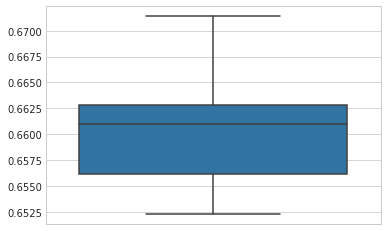

In [19]:
pca_lr_nested_cv_f1_scores = joblib.load('pca_lr_nested_cv_f1_scores.pkl')

plot_cv_scores(pca_lr_nested_cv_f1_scores)

In [18]:
rfe_lr_pipe = Pipeline([('variance', VarianceThreshold()),
                    ('scaler', StandardScaler()),
                    ('rfe', RFE(LogisticRegression(class_weight='balanced', random_state=348744), step=4)),
                    ('lr', LogisticRegression(class_weight='balanced', random_state=621473))])

param_grid = dict()
param_grid['lr__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid['rfe__n_features_to_select'] = list(range(5, 18, 5))
param_grid['rfe__estimator__C'] = [0.1, 1, 10]

inner_cv = StratifiedKFold(n_splits=10, random_state=975428)
outer_cv = StratifiedKFold(n_splits=10, random_state=248733)

gs_cv = GridSearchCV(rfe_lr_pipe, param_grid=param_grid, n_jobs=-1, scoring='f1_weighted', cv=inner_cv, verbose=10)

rfe_lr_nested_cv_f1_scores = cross_val_score(gs_cv, X, y, cv=outer_cv, verbose=10)

joblib.dump(rfe_lr_nested_cv_f1_scores, 'rfe_lr_nested_cv_f1_scores.pkl', compress=1)

print("##### Generalization F1 Score: mean =", np.mean(rfe_lr_nested_cv_f1_scores), "std =", np.std(rfe_lr_nested_cv_f1_scores))
print()

##### Generalization F1 Score: mean = 0.681933347276 std = 0.0138063133181

[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_f

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.651657836935674, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6910676657095496, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6638198729632808, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6642357834399357, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.0s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6583794256863126, total=   1.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6540355486754399, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6550763118902451, total=   1.5s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6469233962963343, total=   1.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6488883914690092, total=   1.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.65425

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6615631645274811, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6777877677775668, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.65487323175268, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6614512976457314, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6572502343497404, total=   1.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6607810

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6619732931951922, total=   1.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6760152137871852, total=   1.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6689162458394318, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6680879603310997, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6514155650535819, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_t

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6488883914690092, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6469233962963343, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6550763118902451, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6542247675922781, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.1s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6646086963153641, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6650089246013838, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6777877677775668, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.65487323175268, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6614512976457314, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6572502343497404, t

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   10.0s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6680879603310997, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6544659986283866, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6572028543557362, total=   2.0s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6638198729632808, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6579921947543301, total=   2.0s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6782875276905839, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10,

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.2s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6540355486754399, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6615631645274811, total=   2.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6550763118902451, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6526481174732627, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6650089246013838, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6777877677775668, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   14.0s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6840851492621902, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6870791521739077, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6613335377737222, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6823373598808455, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6751363739813862, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6852159379383045, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6642080589355821, total=   1.7s
[CV] rfe__n_featu

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.8s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6605118013249875, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6690376887221674, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6582618086354602, total=   1.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6817465330511044, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6676301848218626, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_featur

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   18.8s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6823373598808455, total=   2.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6896691682871496, total=   2.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6852159379383045, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6642080589355821, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.655323912910942, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.707141543749991, total=   1.7

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.5s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6690376887221674, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6676301848218626, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6817465330511044, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6602053767653817, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6643923408174071, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6605535224302927, total

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   24.4s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.655323912910942, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6583690129154917, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.707141543749991, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6896691682871496, total=   2.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6528736560386167, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6533197978005811, tot

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   26.8s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6605535224302927, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6794557341596991, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6662225897735493, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.662421353332776, total=   1.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6870791521739077, total=   1.4s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6840851492621902, to

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   30.5s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6821324970513382, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6698146029724358, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6580438097092687, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6684068494520877, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6615867702660116, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6643868797318958,

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   33.5s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1, score=0.6943567921659374, total=   2.0s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1, score=0.707141543749991, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.656691686422153, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6587628597422474, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6528736560386167, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6533087320661123, total=   2.0s
[

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   37.0s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6751363739813862, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6615300907406627, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6825259969117572, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6852159379383045, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6851786242547439, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=10

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   40.6s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6636034240129901, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6643868797318958, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6792485560628233, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6669990034068223, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6613335377737222, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_sele

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   44.5s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6580438097092687, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1, score=0.6700087487300969, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1, score=0.6821324970513382, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6682127332476204, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6615867702660116, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6643868797318958, total=   1.

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   48.7s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6608127598045087, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6571563065820768, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.661477088651671, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6601469054751791, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6645588885624678, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6700087487300969, total=   1.8s
[CV] rfe__

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   52.5s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6528736560386167, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6533087320661123, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6608127598045087, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6601469054751791, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1, score=0.6645588885624678, total=   1.4s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.661477088651671, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   56.9s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.656691686422153, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.707141543749991, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6587628597422474, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6528736560386167, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6533087320661123, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6608127598045087, total=  

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.0min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6943567921659374, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.707141543749991, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6587628597422474, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6528736560386167, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6533087320661123, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6608127598045087, total=   1.9s
[CV] r

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6943567921659374, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.707141543749991, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.656691686422153, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6896691682871496, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6587628597422474, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6528736560386167, total=   1.6s
[C

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.2min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6896691682871496, total=   2.3s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6943567921659374, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.707141543749991, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.656691686422153, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6587628597422474, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6533087320661123, tota

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.3min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.656691686422153, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6587628597422474, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6533087320661123, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6528736560386167, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6608127598045087, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6601469054751791, total=   1.7

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  1.4min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6528736560386167, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6533087320661123, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6608127598045087, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6601469054751791, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6645588885624678, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6700087487300969, total

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  1.4min


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6571563065820768, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6645588885624678, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6601469054751791, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.663265428560801, total=   2.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1000 ....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1000 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6700087487300969, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6821324970513382, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  1.5min


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6580438097092687, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6821324970513382, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6615867702660116, total=   1.3s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6682127332476204, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6643868797318958, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6613335377737222, total

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.6min finished


[CV] ....................... , score=0.6763840228515103, total= 1.6min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6644490728666342, total=   1.3s
[CV] rfe__n_features_to_select=10, rf

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6625810424601775, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6673354708908354, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6554555051502831, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6647516230767195, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6745755744795399, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6642080589355821, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator_

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.657508207531657, total=   1.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6490565360062374, total=   1.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.664874278260465, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6613265212066254, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6566642295662927, total=   1.5s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6522653108671004, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estima

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.654678288324331, total=   0.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6642196001347807, total=   0.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6584079264808064, total=   0.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6558615571299345, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6741019446589324, total=   1.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6602427151295133, total=   1.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6644490728666342, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6625810424601775, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.3s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6473809210207607, total=   1.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6474832950438931, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6788625590898152, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6473583588004204, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6498883352547066, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.8s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6601534676541352, total=   1.6s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.664874278260465, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6754979767869377, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.654678288324331, total=   0.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6613265212066254, total=   2.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    9.8s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6745755744795399, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6554555051502831, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6647516230767195, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6673354708908354, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6788625590898152, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.1s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6490565360062374, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6601534676541352, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.664874278260465, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6754979767869377, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6613265212066254, total=   2.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_feature

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   13.5s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6798339442226191, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6772119206067694, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6764439427862997, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6617336162878702, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6843849412391354, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6639891053219636,

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.1s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6613662337109089, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6591690854847762, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6518002485185268, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6609722640711505, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6638614912498799, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.67789337952

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   18.4s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6764439427862997, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6617336162878702, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6852159379383045, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6843849412391354, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6639891053219636, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6946710861334532, total=   1.

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   20.9s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6778933795281116, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6561328726758366, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6638614912498799, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6662923295098282, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6594287525583866, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6655635999349576, total

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   24.0s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6524179247601228, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6548631708221903, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6530116510056562, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6613662337109089, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6609722640711505, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   26.6s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6771182970073292, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6587866608001276, total=   1.4s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6772119206067694, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6798339442226191, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6619230896283556, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6764439427862997, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   29.9s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6563276470946232, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6662811126242617, total=   1.6s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6592266091367115, total=   1.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.67786662834396, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6653604845564964, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   32.9s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6513257418099779, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6534002473765691, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6541831799530202, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6554555051502831, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1, score=0.6623874055597551, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=15

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   36.5s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6619230896283556, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6764439427862997, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6798339442226191, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6852159379383045, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6843849412391354, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6946710861334532, total=   1.

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   40.1s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6618772339369526, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6651132488174561, total=   1.3s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6589780471007046, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6771182970073292, total=   1.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1, score=0.6772119206067694, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   43.9s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1, score=0.6642531918894785, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6662811126242617, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6592266091367115, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6653604845564964, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6589780471007046, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6616730773363858, total=   1.

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   48.0s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6623874055597551, total=   1.3s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6521892528321628, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6607630774459857, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6642531918894785, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.67786662834396, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6601469054751791, total=   2.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   52.0s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6541831799530202, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6554555051502831, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6617600594052812, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6607630774459857, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6642531918894785, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6601469054751791, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   56.1s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6513257418099779, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6534002473765691, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6554555051502831, total=   1.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6541831799530202, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10, score=0.6623874055597551, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6617600594052812, total

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.0min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.7067060366843281, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6513257418099779, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6946710861334532, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6534002473765691, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6554555051502831, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6541831799530202, total=   1.9s
[CV] 

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6946710861334532, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6639891053219636, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6513257418099779, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.7067060366843281, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6534002473765691, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6903721291531875, total=   3.1s
[

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.2min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6946710861334532, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6513257418099779, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.7067060366843281, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6534002473765691, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6554555051502831, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6541831799530202, t

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.2min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6554555051502831, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6541831799530202, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6617600594052812, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6607630774459857, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100, score=0.6521892528321628, total=   1.4s
[CV] rfe__n_features_to_select=15,

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  1.3min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6554555051502831, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6541831799530202, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6601469054751791, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6617600594052812, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6607630774459857, total=   1.7s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6623874055597551, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  1.4min


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6623874055597551, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6521892528321628, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6607630774459857, total=   1.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.665760867697312, total=   2.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6617600594052812, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6642531918894785, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  1.5min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6642531918894785, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.665760867697312, total=   2.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6565223862735549, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.67786662834396, total=   2.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6592266091367115, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6653604845564964, total=  

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.6min finished


[CV] ....................... , score=0.6886713916051924, total= 1.6min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6572024416986504, total=   1.2s
[CV] rfe__n_features_to_select=10, rf

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6630620609733281, total=   1.4s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6745755744795399, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.656056995773788, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6428653667951517, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6647516230767195, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6943567921659374, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator_

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.0s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6565317639391433, total=   1.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6455411397288715, total=   1.5s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6452759297030002, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6513714786289175, total=   1.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6512775520400114, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6530867301804381, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__esti

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6520779463064563, total=   1.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6638443824602959, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6550763118902451, total=   0.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6640345212570745, total=   0.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6556683573042227, total=   0.9s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6584079264808064, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estim

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6616300244686811, total=   1.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6740697188409098, total=   1.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6630620609733281, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6572024416986504, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6745755744795399, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_t

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.2s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6489801005172652, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6910676657095496, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6943567921659374, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6428653667951517, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6452759297030002, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.8s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6672416241307707, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6652261406659947, total=   2.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6512775520400114, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6747282151008124, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6550763118902451, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    9.6s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6745755744795399, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.656056995773788, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6669480578349313, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6647516230767195, total=   2.1s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6638198729632808, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   11.8s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6565317639391433, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6513714786289175, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6747282151008124, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6512775520400114, total=   1.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6528575259670326, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6638443824602959, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   13.4s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6603022239988517, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6810952284402527, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6745755744795399, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6617336162878702, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6823373598808455, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6949135554345535,

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   15.8s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6610272332417928, total=   1.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6669727549725459, total=   2.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.655466550813088, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6573837586967898, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6557107500887489, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_feature

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   18.3s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6745755744795399, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6603022239988517, total=   2.0s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6617336162878702, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6823373598808455, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6849402478858122, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6852159379383045, total=   1.

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   20.8s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6710515769750376, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6606002422377599, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6592028377025524, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6616389575496894, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6651696297544104, total=   1.2s
[CV] rfe__n_features_to_selec

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   23.7s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6949135554345535, total=   3.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.650544911768396, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6469890921499525, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6521918557445567, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6502874300205107, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   26.2s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6656861775879586, total=   1.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6778933795281116, total=   1.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6810952284402527, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6604976039567817, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6751363739813862, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6823373598808455, tot

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   29.7s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6714403189310807, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6605949562835289, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6649725913387474, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6593949384507068, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6614253941306377, total=   1.1s
[CV] rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   32.6s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6513375255335715, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.647574261037326, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6527671188239541, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6520814348434044, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6594243951472814, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6593597759711377, total=   1.9

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   36.1s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6751363739813862, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6823373598808455, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6852159379383045, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6617336162878702, total=   2.1s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6849402478858122, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5,

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   39.5s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6593949384507068, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6614253941306377, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.666841220990859, total=   1.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6782807305026181, total=   1.3s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1, score=0.6810952284402527, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   43.3s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1, score=0.6680771955905446, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6566948434822383, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6605949562835289, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6714403189310807, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6651696297544104, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6595922312700992, total=   1.

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   47.5s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6573658348179486, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6564541307130267, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6608097109833269, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6680771955905446, total=   2.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6566948434822383, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6781002784733379, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV] rfe_

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   51.3s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6520814348434044, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6596221444045635, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6527671188239541, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6593597759711377, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1, score=0.6608097109833269, total=   1.3s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6573658348179486, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   55.5s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.707141543749991, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.6946710861334532, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6513375255335715, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6520814348434044, total=   1.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6527671188239541, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   60.0s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6477711840880802, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.707141543749991, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6513375255335715, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6950184501309141, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6520814348434044, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6527671188239541, total=   1.9s
[CV] r

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6513375255335715, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6946710861334532, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6477711840880802, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6950184501309141, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6527671188239541, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, 

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.2min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6477711840880802, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.707141543749991, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6520814348434044, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6527671188239541, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6596221444045635, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.2min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6527671188239541, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6520814348434044, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6596221444045635, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6593597759711377, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6573658348179486, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=15

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  1.3min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6527671188239541, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6520814348434044, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6596221444045635, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6593597759711377, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6608097109833269, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6564541307130267, total

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  1.4min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6564541307130267, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6671575811858671, total=   2.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6573658348179486, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1000 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6781002784733379, total=   1.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6680771955905446, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1000 ....
[CV]  rfe__n_featur

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  1.5min


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6714403189310807, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6671575811858671, total=   3.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6651696297544104, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6605949562835289, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6614253941306377, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.666841220990859, total=

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.6min finished


[CV] ....................... , score=0.6830255729662923, total= 1.6min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.8min remaining:    0.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6636386341502344, total=   2.1s
[CV] rfe__n_features_to_select=10, rf

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6593721331641116, total=   2.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6487416711985883, total=   2.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6642080589355821, total=   2.3s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6949176551965761, total=   2.4s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6912581686170868, total=   2.3s
[CV]  rfe__n_featu

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6570775503770913, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6523209051917646, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6631087689013547, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6563749037810024, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6598002428087385, total=   1.9s
[CV] rfe__n_fe

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6619867859039953, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6514704410108332, total=   2.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6577779698470999, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6551975811083484, total=   2.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6532712814024942, total=   2.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6647946355000138, total=   2.2s
[CV] rfe__n_features_to_select=5, rfe__estim

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.5s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6781002784733379, total=   1.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6538996300906716, total=   2.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6899446884466224, total=   2.5s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6636386341502344, total=   2.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6807779434457342, total=   2.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6626661672822205, to

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6574829823227062, total=   2.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6912581686170868, total=   2.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6949176551965761, total=   2.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6642080589355821, total=   2.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6487416711985883, total=   2.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6523209051917646, to

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   10.4s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6647946355000138, total=   2.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6777383720063851, total=   2.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.658244768523371, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6659813515502424, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6781002784733379, total=   1.3s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6661509811093999, 

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   13.6s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6636386341502344, total=   3.4s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6807779434457342, total=   3.4s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6626661672822205, total=   3.3s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6659134253073448, total=   3.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6593721331641116, total=   3.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   16.9s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6563749037810024, total=   1.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6619867859039953, total=   2.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6551975811083484, total=   2.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6532712814024942, total=   3.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6577779698470999, total=   2.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.66479463550

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   18.7s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6899446884466224, total=   2.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6807779434457342, total=   2.2s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6811822231008392, total=   2.4s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6779398406788512, total=   2.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6802136617863955, total=   2.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6825259969117572,

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   22.3s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.662338570236595, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6624304265397192, total=   2.4s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6677722636879557, total=   1.5s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6560452078466348, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6616477291847932, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_feature

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   25.8s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6865339690922697, total=   2.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6825259969117572, total=   3.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6851786242547439, total=   2.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.7081649418228579, total=   2.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6524435869863903, total=   2.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6603949551391216, total=   

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   28.9s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6624304265397192, total=   2.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6822950941801228, total=   2.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6674359352495584, total=   2.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6680834531465166, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.661581105882042, total=   1.7s
[CV]  rfe__n_features_to_selec

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   33.8s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6965379490168117, total=   3.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6643015852473676, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6575563575662285, total=   3.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6568223265559522, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.666090614258173, total=   3.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   37.6s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6807370333057151, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6811822231008392, total=   2.4s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6783163320020705, total=   2.4s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6807779434457342, total=   2.4s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6899446884466224, total=   2.6s
[CV] rfe__n_features_to_sele

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   42.0s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6679574037937949, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6626075548852648, total=   2.3s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.661272927220876, total=   2.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6620302255042001, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6820557990333336, total=   2.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   46.2s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6613756653231294, total=   2.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6534118682478642, total=   2.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6658705806375477, total=   2.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1, score=0.6623210074066384, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6574104385549853, total=   2.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=15

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   52.0s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6802136617863955, total=   3.1s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6807779434457342, total=   3.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6899446884466224, total=   3.4s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6825259969117572, total=   3.3s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6811822231008392, total=   3.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6865339690922697, total=   3.

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   56.7s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6631373212628502, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6643444628277795, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6687824776632284, total=   1.9s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6619008814469912, total=   2.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6680834531465166, total=   2.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.681315756764279, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:  1.0min


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6562318688616267, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1, score=0.6682127332476204, total=   2.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6679574037937949, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6620302255042001, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1, score=0.682248382525301, total=   2.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6682795585014601, total=   1.7

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:  1.1min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6572079543255865, total=   3.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6610687207185661, total=   2.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6625165654750168, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6628029562533543, total=   3.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6662867701182708, total=   3.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.682248382525301, total=   2.9s
[CV]  rfe_

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.2min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6577397612479058, total=   3.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6662867701182708, total=   3.3s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6658705806375477, total=   3.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1, score=0.6625165654750168, total=   2.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6628029562533543, total=   3.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6572079543255865, total=   3.6s
[CV

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:  1.4min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.707946635395079, total=   2.5s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.6851786242547439, total=   2.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6613756653231294, total=   2.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6534118682478642, total=   2.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6658705806375477, total=   2.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6577397612479058, total=  

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.5min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6965379490168117, total=   2.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6613756653231294, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6534118682478642, total=   2.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.707946635395079, total=   3.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6658705806375477, total=   2.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6577397612479058, total=   3.0s
[CV] r

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.6min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6865339690922697, total=   3.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6965379490168117, total=   3.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6851786242547439, total=   3.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.707946635395079, total=   3.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6613756653231294, total=   3.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6534118682478642, total=   3.5s
[C

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.7min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6851786242547439, total=   2.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6965379490168117, total=   2.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6613756653231294, total=   2.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.707946635395079, total=   2.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6534118682478642, total=   2.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6658705806375477, tot

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.8min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=100, score=0.6965379490168117, total=   2.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=100, score=0.707946635395079, total=   2.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6534118682478642, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6613756653231294, total=   3.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6658705806375477, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.65799760075132, total=   3.0s
[C

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  2.0min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6658705806375477, total=   3.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6577397612479058, total=   3.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.65799760075132, total=   3.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6662867701182708, total=   3.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6610687207185661, total=   3.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6628029562533543, total= 

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  2.1min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6662867701182708, total=   2.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6610687207185661, total=   2.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6628029562533543, total=   2.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6625165654750168, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1000 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6679574037937949, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1000 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.66821273324

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  2.2min


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6679574037937949, total=   2.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6620302255042001, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6682127332476204, total=   3.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.682248382525301, total=   3.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6633339303444621, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_selec

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  2.4min finished


[CV] ....................... , score=0.6831879989054217, total= 2.4min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.2min remaining:    0.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.655466321312781, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6570043588809868, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6657198748646951, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6642080589355821, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6472275460781451, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6740622283243629, total=   2.0s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6766892229607187, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6560600521795985, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6490204873356403, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6596028343719156, total=   1.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.658870130376387, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6573387051061194, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.649568

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6560353431917668, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6523281901343214, total=   0.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.662636648196282, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6536734863242419, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6570331849085626, total=   1.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.675097

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6626609965757723, total=   1.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6677521754446066, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.655466321312781, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6570043588809868, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.65448681295618, total=   2.0s
[CV]  rfe__n_features_to_sele

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6800361726682586, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6525504759901689, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6472275460781451, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6560600521795985, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6495682146533615, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6573387051061194, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, l

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.2s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6622608316844032, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6737120170751972, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6523281901343214, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6536734863242419, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.662636648196282, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   10.2s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6570043588809868, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6677521754446066, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6657198748646951, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6642080589355821, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6673354708908354, total=   2.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6472275460781451

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.3s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6573387051061194, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6490204873356403, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6596028343719156, total=   1.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6506839737587727, total=   2.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.658870130376387, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.656035343191

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   13.9s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6626609965757723, total=   1.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6583292333083994, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6602928225785639, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6719739717758211, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6581344275496678, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6861575221685017

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.6s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6647868953698792, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6540946642919719, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6540471532503652, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6625048518298111, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6593331452029823, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6647447675829044, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=5, rfe__estimator__

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   19.2s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6581344275496678, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6830917432812679, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6861575221685017, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6849402478858122, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6842213804273882, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6777480114606067, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 .

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.7s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6773121153306262, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6647236887375908, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.657570340235035, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6651696297544104, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6580079357623997, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_selec

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   24.7s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.688787483385203, total=   2.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6777480114606067, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6485649572534358, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6572689173933677, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6611752543684621, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_se

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.2s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6580079357623997, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6639230288897999, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6771182970073292, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6608967356708458, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6600879949339178, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6587187398791595, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, 

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   31.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6608238214356718, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6628973448999265, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6774927494031466, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6655026725707407, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6577447108495647, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   34.2s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1, score=0.6844138436613468, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6578598648956873, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6501313393775783, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6625472804806518, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.653865930840094, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6538415540970641, total=   1.8s

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   38.0s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6721679028264862, total=   2.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6840083264470194, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6849402478858122, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6861575221685017, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6844138436613468, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6777328130885854, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 .

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   41.4s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6577447108495647, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6653604845564964, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.658594926562159, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6614688757118147, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6641069297842004, total=   1.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6781002784733379, total=

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   45.6s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6628973448999265, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6656973334441638, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6575392819906565, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6653604845564964, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6612646289681735, total=   1.1s
[CV] rfe__n_features_to_select=5, 

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   50.0s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6597261739943708, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6548788165628338, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6651346264352384, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6628973448999265, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.66399

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   54.1s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6625472804806518, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.653865930840094, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6643868797318958, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1, score=0.6606203656907801, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6597261739943708, total=   2.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6534376474950544, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   58.4s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6578598648956873, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.6844138436613468, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6501313393775783, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6625472804806518, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.653865930840094, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.1min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6777328130885854, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.688787483385203, total=   3.1s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6844138436613468, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6578598648956873, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6501313393775783, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6625472804806518, total=   1.8s
[CV]  r

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6578598648956873, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6777328130885854, total=   2.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6501313393775783, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.688787483385203, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6625472804806518, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, r

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.2min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.688787483385203, total=   2.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6844138436613468, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6501313393775783, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6578598648956873, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6625472804806518, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.653865930840094, tot

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.3min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6501313393775783, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6578598648956873, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6625472804806518, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.653865930840094, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6643868797318958, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=15,

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  1.4min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6625472804806518, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.653865930840094, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6643868797318958, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6606203656907801, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6548788165628338, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6534376474950544, total=

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  1.5min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6643868797318958, total=   2.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6606203656907801, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6534376474950544, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.677299034611417, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6651346264352384, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6597261739943708, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=15, rfe__estimator_

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  1.6min


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6575392819906565, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6653604845564964, total=   1.4s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6656973334441638, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.658594926562159, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6612646289681735, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_selec

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.7min finished


[CV] ....................... , score=0.6573854684823657, total= 1.7min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.9min remaining:    0.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6806206102477218, total=   1.3s
[CV] rfe__n_features_to_select=10, rf

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6708686190454284, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6491850722576263, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6638198729632808, total=   1.6s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6483800481154436, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6651779338893096, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6848391164316966, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6594243951472814, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.656135632980357, total=   1.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6492029209684723, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6601895000355632, total=   1.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6642531918894785, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.660417

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.65935335810182, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.676644634756829, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6497240039177797, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6572767815915324, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6546646036464691, total=   1.0s
[CV] rfe__n_featu

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.4s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6572223005343251, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6752374074096983, total=   1.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6579794015946103, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6806206102477218, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6708686190454284, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_t

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.4s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6476081770838295, total=   1.5s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6483800481154436, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6756944208307655, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6594243951472814, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6481450304478166, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6528757904829979, 

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.9s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6604175122224908, total=   2.5s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6642531918894785, total=   1.3s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6564656166918797, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.65935335810182, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6497240039177797, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.676644634756829, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr_

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   10.0s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6651779338893096, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6848391164316966, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6491850722576263, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6638198729632808, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.7069550002611886, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   11.8s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6528757904829979, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6564656166918797, total=   1.7s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.656135632980357, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6601895000355632, total=   1.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6492029209684723, total=   1.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6534416021087303, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   13.4s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6604976039567817, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6811822231008392, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6717924798766948, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6507232056960496, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6851786242547439, total=   1.5s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6865339690922697, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.2s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6602406342806145, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6643090939527752, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6552789570653696, total=   1.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6640401003701528, total=   1.5s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6594329527109516, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.66079762039

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   18.5s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6717924798766948, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6507232056960496, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6837149523350452, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6865339690922697, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6851786242547439, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5,

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.1s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6613600121662574, total=   2.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6784877092005626, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6676420834404003, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6541831799530202, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6608348500309513, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6587866608001276, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   23.8s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6767833878401839, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.7081649418228579, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.688787483385203, total=   2.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6525440827537026, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6509314964058743, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6631304212808959, tot

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   26.6s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6650685447259078, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6773121153306262, total=   1.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6604976039567817, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6810952284402527, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6846605681790621, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6509178564458508, tot

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   30.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6676301848218626, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.67888834756916, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6549531352755483, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6624733775674055, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   33.1s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6513094105535964, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1, score=0.6767833878401839, total=   2.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6641127368442273, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6535877695824024, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6619753127997055, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6592266091367115, total=   1.8

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   36.5s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6721805205840152, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6846605681790621, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6865339690922697, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6509178564458508, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6851786242547439, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5,

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   40.0s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6612264529798059, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6624733775674055, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6587809495477326, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6654456391511187, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6780870708319652, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1, score=0.6810952284402527, total= 

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   43.9s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6556708256037375, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1, score=0.6601262607974345, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6646782509339246, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6549531352755483, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6676301848218626, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6614242518992057, total=   1.

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   48.1s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6619753127997055, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6601262607974345, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6592266091367115, total=   2.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6606272653754115, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6646270452499696, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6556708256037375, total=   1.3s
[CV] rfe_

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   52.1s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6645054158379331, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1, score=0.688787483385203, total=   3.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6535877695824024, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6619753127997055, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6601262607974345, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6592266091367115, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV] 

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   56.3s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6523389496929156, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6513094105535964, total=   1.5s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.6767833878401839, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6645054158379331, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6535877695824024, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_selec

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.0min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.688787483385203, total=   2.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6767833878401839, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.707946635395079, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6513094105535964, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6523389496929156, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6645054158379331, total=   1.6s
[CV] rfe

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.707946635395079, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6513094105535964, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6767833878401839, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6523389496929156, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.688787483385203, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.2min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6523389496929156, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6513094105535964, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.707946635395079, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6767833878401839, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6645054158379331, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6535877695824024, to

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.3min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=100, score=0.6767833878401839, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6645054158379331, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6513094105535964, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6535877695824024, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6592266091367115, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10,

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  1.3min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=100, score=0.688787483385203, total=   3.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6535877695824024, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6592266091367115, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6601262607974345, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6556708256037375, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6619753127997055, total= 

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  1.4min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6601262607974345, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6619753127997055, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6556708256037375, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6606272653754115, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1000 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6646270452499696, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1000 ....
[CV]  rfe__n_featur

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  1.5min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.67888834756916, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6614242518992057, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6676301848218626, total=   2.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6587809495477326, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6624733775674055, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6780870708319652, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.6min finished


[CV] ....................... , score=0.6808978091984544, total= 1.6min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 10.6min remaining:    0.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6538996300906716, total=   1.5s
[CV]  rfe__n_features_to_select=5, rf

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6745464299921894, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6713805487357917, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6599318556088416, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6642080589355821, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6788625590898152, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6912581686170868, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator_

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6574331462089608, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6521523721309835, total=   1.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6576745953622712, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6607502944216941, total=   1.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6530803902156036, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_f

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6622691856983115, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6765982281250974, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6590664207655745, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6600265466739494, total=   1.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6512519218595257, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_f

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6745464299921894, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6636386341502344, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6538996300906716, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6713805487357917, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6788625590898152, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6912581686170868, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6574331462089608, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6530803902156036, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6576745953622712, total=   1.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.1s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6611631209867332, total=   2.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6588390270884679, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6765982281250974, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6622691856983115, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6512519218595257, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   10.1s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6538996300906716, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6745464299921894, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6663920437821166, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6599318556088416, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6642080589355821, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.1s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6530803902156036, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6607502944216941, total=   1.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6521523721309835, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6576745953622712, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6588390270884679, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.66226918569

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   13.7s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6772119206067694, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6636386341502344, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6886294806292503, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6751070092447777, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6740622283243629, total=   2.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6642080589355821,

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.7s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.663901467947305, total=   2.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6574140406699444, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6654537168290872, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6659030284383998, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.66196366594151, total=   1.4s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6589187734004779, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   19.1s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6886294806292503, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6836648011562282, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6790714083898801, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6642080589355821, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6740622283243629, total=   2.5s
[CV] rfe__n_features_to_select=10,

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.6s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6805734506352161, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.663901467947305, total=   2.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6689636795187427, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6659030284383998, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6626102801180737, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6556995942960813, total=

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   24.3s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6522737470901915, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6528973817024547, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6949176551965761, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6912581686170868, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6740622283243629, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6641200120465703, to

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.3s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6660403585413177, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6627934094432973, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6790134011048646, total=   1.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6772119206067694, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6636386341502344, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6897568790368839, to

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   31.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6691445379657281, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6654274580298029, total=   1.5s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6817316553073929, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6562831012407768, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6635976400372632, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   33.9s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1, score=0.6949176551965761, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6532920823525544, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6528612706791382, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1, score=0.6912581686170868, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6558941317469199, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6643090939527752, total=   2.1s

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   37.8s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6836648011562282, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6642080589355821, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6790714083898801, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6949176551965761, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6912581686170868, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=10

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   41.1s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6635976400372632, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6615631645274811, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6639646382459152, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6662225897735493, total=   1.3s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6788059483279614, total=   1.3s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1, score=0.6636386341502344, total= 

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   45.4s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6652318337883523, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6562831012407768, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6635976400372632, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6693382675742138, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6615631645274811, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.664159722153347, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 ......

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   49.7s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.663343029635161, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6580001496955385, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6652318337883523, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6593039494168156, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6644821886236941, total=   2.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6629049646314354, total=   2.0s
[CV] rfe__

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   53.7s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6643090939527752, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6558941317469199, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1, score=0.663343029635161, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6592175741031355, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6593039494168156, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe_

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   58.3s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.6912581686170868, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6528612706791382, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6532920823525544, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6558941317469199, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6643090939527752, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6592175741031355, total=

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.0min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6532920823525544, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6949176551965761, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6740622283243629, total=   2.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6912581686170868, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6528612706791382, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6643090939527752, total=   1.8s
[CV] r

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6642080589355821, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6532920823525544, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6912581686170868, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6949176551965761, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6528612706791382, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6740622283243629, total=   3.2s
[

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.2min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6912581686170868, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6532920823525544, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6528612706791382, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6643090939527752, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6592175741031355, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.3min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=100, score=0.6740622283243629, total=   3.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6528612706791382, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6532920823525544, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6558941317469199, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6643090939527752, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10,

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  1.4min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6558941317469199, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6643090939527752, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6592175741031355, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6580001496955385, total=   1.3s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6593039494168156, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.663343029635161, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  1.5min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6593039494168156, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6592175741031355, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6644821886236941, total=   2.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6674594220414792, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.663343029635161, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1000 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.662904964631

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  1.6min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6674594220414792, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6817316553073929, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6562831012407768, total=   1.4s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6635976400372632, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6693382675742138, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.664159722153347, total=

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.7min finished


[CV] ........................ , score=0.685603797264728, total= 1.7min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 12.2min remaining:    0.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6517255976106547, total=   1.7s
[CV]  rfe__n_features_to_select=5, rf

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.655311221450971, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6482157079341655, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6740622283243629, total=   2.0s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6912581686170868, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1,

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.662081345608479, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.649104976634784, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6568786692246251, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6616495895681219, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6742862026476565, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6574663536754386, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6636386341502344, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6517255976106547, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6498780183892389, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.655311221450971, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6912581686170868, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6552708703217416, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6483345669715503, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6520873998287172, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6573011159346805, t

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.2s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6638443824602959, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6546488632446228, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6754765853650694, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.662081345608479, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6623231806465468, total=   2.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6568786692246251, 

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   10.4s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6574663536754386, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6612351838440708, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6498780183892389, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6788625590898152, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6716031132984157, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.5s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6546488632446228, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6520873998287172, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.662081345608479, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6754765853650694, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6638443824602959, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_feature

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   13.9s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.659111150035965, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6636386341502344, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6733308064136115, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6751070092447777, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6627876360918874, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6740622283243629, 

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.7s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6600097338865892, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6547477525884848, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6586054020826996, total=   1.7s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6544786760602981, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6609119052715695, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6646270452499696, total=   2.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=5, rfe__estimator__

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   19.2s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6751070092447777, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6614242518992057, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6627876360918874, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6716031132984157, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6740622283243629, total=   2.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5,

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.9s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.677299034611417, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6545632091116939, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6652513172329609, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6667697748929795, total=   1.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6610327979125442, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_selec

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   24.7s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6574474514141873, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6912581686170868, total=   2.0s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6740622283243629, total=   2.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6497383529778392, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6613839483208788, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6547477525884848, t

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.5s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6775059018260984, total=   1.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6596878630856942, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6734977715488001, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6636386341502344, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6751070092447777, total=   1.6s
[CV] rfe__n_features_to_sele

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   31.1s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6627432438072799, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6654456391511187, total=   1.5s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6788478671884484, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6545528488895571, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6616220142964284, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   34.4s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1, score=0.6912581686170868, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.650320450100808, total=   2.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.662960201122353, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6555161004879962, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6566584415463472, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, r

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   38.0s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6734977715488001, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6636386341502344, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6751070092447777, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6949176551965761, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6627876360918874, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6716031132984157, total=   1.

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   41.6s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6616220142964284, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6669606735125921, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6646862270492936, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.665091222117542, total=   1.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6780870708319652, total=   1.2s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1, score=0.6596878630856942, total=  

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   45.7s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1, score=0.6788478671884484, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.661819740219127, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6654456391511187, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6545528488895571, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6646862270492936, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6667575302017154, total=   1.2

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   50.1s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6595949432548791, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6552536209776034, total=   1.4s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6611082271489874, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6595866920760945, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6603502358066253, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6652136778565896, total=   2.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV] rfe_

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   54.3s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6578274903107418, total=   2.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6557107500887489, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.663157071344351, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6566584415463472, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1, score=0.6595949432548791, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6603502358066253, total=   2.0s
[CV]

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   58.5s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6578274903107418, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.650320450100808, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.6912581686170868, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.663157071344351, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6557107500887489, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6566584415463472, total=  

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.1min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6949176551965761, total=   2.0s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6740622283243629, total=   2.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=10, score=0.6912581686170868, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6578274903107418, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.650320450100808, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.663157071344351, total=   2.0s
[CV] rfe

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6912581686170868, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6578274903107418, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6740622283243629, total=   3.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.650320450100808, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.663157071344351, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6557107500887489, total=   1.7s
[

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.2min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6578274903107418, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.650320450100808, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.663157071344351, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6557107500887489, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100, score=0.6595949432548791, total=   1.3s
[CV] rfe__n_features_to_se

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.3min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.650320450100808, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6578274903107418, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.663157071344351, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6557107500887489, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6566584415463472, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6595866920760945, total=   1.9s

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  1.4min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.663157071344351, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6557107500887489, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6595949432548791, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6566584415463472, total=   2.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6595866920760945, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6552536209776034, total=

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  1.5min


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6595949432548791, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6566584415463472, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6595866920760945, total=   1.9s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6552536209776034, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6605469679760914, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6627432438072799, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  1.6min


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6627432438072799, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6788478671884484, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.661819740219127, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6654456391511187, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6667575302017154, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_selec

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.7min finished


[CV] ....................... , score=0.6614724925299904, total= 1.7min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.9min remaining:    0.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6644490728666342, total=   1.4s
[CV] rfe__n_features_to_select=10, rf

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6637232223593945, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6745464299921894, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6700578414554631, total=   1.7s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6622057217795629, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6612107622098621, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6503698680159822, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimato

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.661819740219127, total=   2.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6588128350392051, total=   1.7s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6553200994590613, total=   1.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6465081631946097, total=   1.6s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6611568164235929, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6510610

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6492895103789318, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6614930326802038, total=   2.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6510457115700892, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6518703601835115, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6756928775888269, total=   1.8s
[CV] rfe__n_fe

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6504180278945311, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.676038301596111, total=   1.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6644490728666342, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6637232223593945, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6745464299921894, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6612107622098621, total=   2.0s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6912581686170868, total=   2.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6503698680159822, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6588128350392051, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6492895103789318, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.4s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6756928775888269, total=   1.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6506560498346966, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6578714850932029, total=   0.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6610368219873727, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6504180278945311, total=   0.9s
[CV] rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   10.3s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.671187616787038, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.661819740219127, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6622057217795629, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6503698680159822, total=   1.6s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6700578414554631, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.4s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.651061054496186, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6553200994590613, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6518703601835115, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6611568164235929, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6602445065659494, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.675692877588

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   13.9s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6772119206067694, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6811735365790946, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6899446884466224, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6655377679046827, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6747039162041388, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6782003802117017,

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.6s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6536756158505486, total=   1.6s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6611795943282281, total=   1.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6656973334441638, total=   2.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6563749037810024, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6657274760403256, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6648404813103073, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   19.1s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6899446884466224, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6747039162041388, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6655377679046827, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6782003802117017, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6880386995252443, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6823373598808455, total=   1.

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.7s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6783200899465078, total=   1.9s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6648404813103073, total=   1.5s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6656973334441638, total=   2.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6676058998130832, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6547263781236021, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6643572242968057, total

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   24.7s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6543948660073039, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6642939177525898, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6882730570813803, total=   3.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6532627881561057, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6657274760403256, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.1s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.653098300845611, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6589721004373519, total=   1.3s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6776864324633676, total=   1.3s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6772119206067694, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6811735365790946, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_se

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   30.9s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6543559496930158, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.67888834756916, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6553104137516428, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6679940027555518, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6616127297106301, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   34.1s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6547871220356264, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.66488232912623, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6532508808921423, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6655239087920771, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6538723206875128, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1, score=0.6611795943282281, total=   1.3s

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   37.4s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6772119206067694, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6904803310088997, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6761974376240428, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6655377679046827, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6787664623080261, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6823373598808455, total=   1.

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   41.1s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.664154015415711, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6538906303408704, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6595566124869864, total=   1.4s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6780464894396983, total=   1.3s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1, score=0.6772119206067694, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1 ....
[CV]  rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   45.4s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6553328763804995, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6553104137516428, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6616127297106301, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6679940027555518, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6645475929852122, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   49.7s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6611795943282281, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6657203931684449, total=   2.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6553328763804995, total=   1.4s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.654552700787929, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6654183855141044, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1 ......
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6567749329966238, total=   2.0s
[CV] rfe__

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   53.6s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1, score=0.6882730570813803, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6650783962192063, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6532508808921423, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6538723206875128, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1, score=0.6611795943282281, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1, score=0.6654183855141044, total=   1.3s
[CV]

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   58.0s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.7077282632220966, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.6823373598808455, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.652314488204433, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6547871220356264, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6650783962192063, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6538723206875128, total=  

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.1min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6547871220356264, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6650783962192063, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6532508808921423, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6538723206875128, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6657203931684449, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10, score=0.6611795943282281, total=   1.3s
[CV

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6787664623080261, total=   2.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.7077282632220966, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.652314488204433, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6882730570813803, total=   3.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6823373598808455, total=   2.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6650783962192063, total=   1.8s
[C

[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.2min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6882730570813803, total=   2.5s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6823373598808455, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.7077282632220966, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.652314488204433, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6547871220356264, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6650783962192063, tot

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.3min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=100, score=0.7077282632220966, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6650783962192063, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6532508808921423, total=   2.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6538723206875128, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6657203931684449, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100, score=0.6611795943282281, total=   1.3

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  1.4min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6650783962192063, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6532508808921423, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6538723206875128, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6657203931684449, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6611795943282281, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_sele

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  1.5min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6538723206875128, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6657203931684449, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6662811126242617, total=   2.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6553328763804995, total=   1.5s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.654552700787929, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6654183855141044, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  1.6min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6662811126242617, total=   2.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6567749329966238, total=   2.1s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6790820238263972, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.654552700787929, total=   2.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6553104137516428, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6679940027555518, total=

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.7min finished


[CV] ....................... , score=0.6970404869697575, total= 1.7min
[CV]  ................................................................
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 15.6min remaining:    0.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001 .
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6637232223593945, total=   1.5s
[CV]  rfe__n_features_to_select=5, rf

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6612351838440708, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6781818378547461, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.648082442654911, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6618994697618079, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6742546122872529, total=   2.1s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.001, score=0.6700578414554631, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator_

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6546890673824044, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6512775520400114, total=   1.4s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6588128350392051, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.656671945631466, total=   1.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001 
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.651872951278033, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6562486

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.665194880711357, total=   1.4s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.657568940346207, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.001, score=0.6552469897130807, total=   1.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6506472425739152, total=   0.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.664402794404274, total=   0.9s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.65926508198077, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator_

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.6s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6550247102930479, total=   1.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6574245383953572, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.001, score=0.6634936648747651, total=   1.1s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6637232223593945, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6745464299921894, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.66444907286663

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.4s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.001, score=0.6781818378547461, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.648082442654911, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6546890673824044, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6588128350392051, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6512775520400114, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.1s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.657568940346207, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6562486368949082, total=   2.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.001, score=0.6552469897130807, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.665194880711357, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.001, score=0.6506472425739152, total=   0.9s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    9.9s


[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6745464299921894, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6600463355639425, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.671187616787038, total=   2.0s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6612351838440708, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6700578414554631, total=   1.8s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.001, score=0.6618994697618079, 

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.2s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.6597660741537248, total=   1.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001, score=0.651872951278033, total=   1.2s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.001 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6562486368949082, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.657568940346207, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6644978322831909, total=   2.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.001, score=0.6552469897130

[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   13.5s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6811735365790946, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6772119206067694, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6899446884466224, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6752641924394598, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6655377679046827, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.01, score=0.6787664623080261,

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.6s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6599751667215972, total=   1.7s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.657626734062236, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.663265428560801, total=   1.2s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6616477291847932, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.01, score=0.6561330322101444, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.01, score=0.6597401133154

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   18.9s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6772119206067694, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6655377679046827, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6752641924394598, total=   1.9s
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6787664623080261, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6872865449612265, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.01, score=0.6618994697618079, total=   1.

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.4s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.6683266580526495, total=   2.6s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.663265428560801, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6568779092130307, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.01, score=0.665760867697312, total=   2.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.01, score=0.6675935130121928, total=   1.7s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01 ...
[CV] rfe__n_features_to_select=

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   24.5s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6953507885419679, total=   2.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6595715336395805, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6515870026570459, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6618994697618079, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.01, score=0.6882730570813803, total=   3.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.01, score=0.6624972230541105, total=   1.5s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.0s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6679263281287541, total=   1.1s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6619084438499344, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.01, score=0.6563290164849048, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1 ...
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6772119206067694, total=   1.6s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=0.1, score=0.6811735365790946, total=   1.5s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1 ..
[CV]  rfe__n_features_to_s

[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   30.8s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6620302255042001, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6663459866034039, total=   1.8s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6634353919821048, total=   1.4s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6562715479159312, total=   1.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=0.1, score=0.6601333022312782, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=0.1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=0.1, score=0.6679814679356908,

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   33.8s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6597593084515501, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6632817671160866, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6521750041328541, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6582199503456465, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6568545091507689, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=0.1 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=0.1, score=0.6603691943387029, total=   2.

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   37.6s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6904803310088997, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6761974376240428, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6657274760403256, total=   1.9s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6787664623080261, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6872865449612265, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=0.1 ...
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=0.1, score=0.6618994697618079, total=   1.

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   41.1s


[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6679814679356908, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6620078429464652, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6667511736477254, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6575072519947264, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6624972230541105, total=   1.5s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=0.1, score=0.6691058753796736, total=   1.3s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__

[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   45.4s


[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6564659032770653, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6679814679356908, total=   1.6s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6620078429464652, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6577110736989119, total=   1.1s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=1 .......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6624972230541105, total=   1.3s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1, score=0.6669479679906847, total=   1.

[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   49.6s


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6582199503456465, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6561240895495702, total=   1.4s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6617756940705326, total=   1.4s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6603691943387029, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1 ......
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1, score=0.6634353919821048, total=   1.4s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.6620302255042001, total=   2.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1, score=0.660133

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   53.6s


[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6634778150780796, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6570487597574074, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6582199503456465, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1, score=0.6617756940705326, total=   1.4s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=1, score=0.6603691943387029, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=1 .....
[CV]  rfe__n_features_to_select=15, rfe

[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   58.0s


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=10, score=0.6953507885419679, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6599551734338908, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6521750041328541, total=   2.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6634778150780796, total=   2.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6570487597574074, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=10 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=10, score=0.6582199503456465, total=

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.1min


[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6634778150780796, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6570487597574074, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=10, score=0.6582199503456465, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10, score=0.6617756940705326, total=   1.3s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10, score=0.6561240895495702, total=   1.3s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=10 .....
[CV]  rfe__n_features_to_select=10, rfe

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6872865449612265, total=   1.8s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6618994697618079, total=   1.7s
[CV] rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=10, score=0.6953507885419679, total=   1.7s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6521750041328541, total=   1.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6599551734338908, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=10, score=0.6634778150780796, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=10 ....


[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.2min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6618994697618079, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=0.1, lr__C=100, score=0.6953507885419679, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6599551734338908, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6521750041328541, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6634778150780796, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=100 ..
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=100, score=0.6582199503456465, t

[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.3min


[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=100, score=0.6953507885419679, total=   2.0s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=5, rfe__estimator__C=1, lr__C=100, score=0.6882730570813803, total=   2.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6599551734338908, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6521750041328541, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6634778150780796, total=   1.6s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=100 ....
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=100, score=0.6570487597574074, total=   1.7s

[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  1.4min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6634778150780796, total=   1.9s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6603691943387029, total=   1.9s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6582199503456465, total=   2.0s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=10, lr__C=100, score=0.6570487597574074, total=   2.1s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV] rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6634353919821048, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__C=100, score=0.6561240895495702, total=   1.5s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=10, lr__

[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:  1.5min


[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6582199503456465, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6561240895495702, total=   1.3s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000, score=0.6617756940705326, total=   1.4s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6683159912077254, total=   2.8s
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6663459866034039, total=   1.8s
[CV] rfe__n_features_to_select=15, rfe__estimator__C=0.1, lr__C=1000 .
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=0.1, lr__C=1000, score=0.6603691943387029, total=   2.0s
[CV] rfe__n_features_to_select=5, rfe__estimator__

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  1.6min


[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=10, rfe__estimator__C=1, lr__C=1000, score=0.6683159912077254, total=   2.8s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6564659032770653, total=   1.2s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6669479679906847, total=   1.3s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=1000 ...
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6679814679356908, total=   2.0s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6624972230541105, total=   1.2s
[CV]  rfe__n_features_to_select=15, rfe__estimator__C=1, lr__C=1000, score=0.6620078429464652, total=   1.5s
[CV] rfe__n_features_to_select=5, rfe__estimator__C=10, lr__C=

[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  1.7min finished


[CV] ....................... , score=0.7056644319875216, total= 1.7min
##### Generalization F1 Score: mean = 0.681933347276 std = 0.0138063133181



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.3min finished


[ 0.67638402  0.68867139  0.68302557  0.683188    0.65738547  0.68089781
  0.6856038   0.66147249  0.69704049  0.70566443]



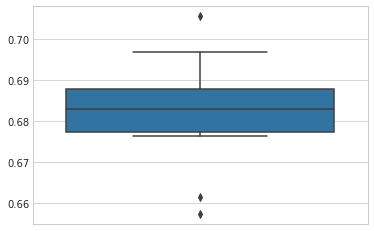

In [20]:
rfe_lr_nested_cv_f1_scores = joblib.load('rfe_lr_nested_cv_f1_scores.pkl')

plot_cv_scores(rfe_lr_nested_cv_f1_scores)